<a href="https://colab.research.google.com/github/ShivinM-17/Chronic_kidney_disease_XAI/blob/main/Chronic_kidney_detection_with_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chronic Kidney Disease with XAI for model explanability


### Importing the modules and packages

In [1]:
# General modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

In [2]:
# Modules for preprocessing, hyperparameters testing and evaluation statistics
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

In [3]:
!pip -q install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.5 MB/s eta 0:00:00


In [4]:
# modules for model training
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from scipy.stats import randint, uniform
from google.colab import drive
import os
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
import pickle

# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

# for styling
plt.style.use('seaborn-whitegrid')

### Loading, preprocessing, visualizing and preparing the datasets

#### Load and checkout the data

In [6]:
# Load the dataset via its path
csv_path = "/content/kidney_disease (1).csv"
data = pd.read_csv(csv_path)
data.head()

id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 columns]

In [7]:
# Check the shape of the data
data.shape

(400, 26)

In [8]:
# Drop the `id` column since of no use
data = data.drop('id', axis = 1)
data.head(5)

age    bp     sg   al   su     rbc        pc         pcc          ba  \
0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr  ...  pcv    wc   rc  htn   dm cad appet   pe  ane classification  
0  121.0  ...   44  7800  5.2  yes  yes  no  good   no   no            ckd  
1    NaN  ...   38  6000  NaN   no   no  no  good   no   no            ckd  
2  423.0  ...   31  7500  NaN   no  yes  no  poor   no  yes            ckd  
3  117.0  ...   32  6700  3.9  yes   no  no  poor  yes  yes            ckd  
4  106.0  ...   35  7300  4.6   no   no  no  good   no   no            ckd  

[5 rows x 25 columns]

In [9]:
# Change the name of the columns for better representation
data.columns = ['age',
                'blood_pressure',
                'specific_gravity',
                'albumin',
                'sugar',
                'red_blood_cells',
                'pus_cell',
                'pus_cell_clumps',
                'bacteria',
                'blood_glucose_random',
                'blood_urea',
                'serum_creatinine',
                'sodium',
                'potassium',
                'haemoglobin',
                'packed_cell_volume',
                'white_blood_cell_count',
                'red_blood_cell_count',
                'hypertension',
                'diabetes_mellitus',
                'coronary_artery_disease',
                'appetite',
                'peda_edema',
                'aanemia',
                'class',
               ]

In [10]:
# Check the datatypes of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      391 non-null    float64
 1   blood_pressure           388 non-null    float64
 2   specific_gravity         353 non-null    float64
 3   albumin                  354 non-null    float64
 4   sugar                    351 non-null    float64
 5   red_blood_cells          248 non-null    object 
 6   pus_cell                 335 non-null    object 
 7   pus_cell_clumps          396 non-null    object 
 8   bacteria                 396 non-null    object 
 9   blood_glucose_random     356 non-null    float64
 10  blood_urea               381 non-null    float64
 11  serum_creatinine         383 non-null    float64
 12  sodium                   313 non-null    float64
 13  potassium                312 non-null    float64
 14  haemoglobin              3

In [11]:
# Get the unique values count of the data
data.nunique()

age                         76
blood_pressure              10
specific_gravity             5
albumin                      6
sugar                        6
red_blood_cells              2
pus_cell                     2
pus_cell_clumps              2
bacteria                     2
blood_glucose_random       146
blood_urea                 118
serum_creatinine            84
sodium                      34
potassium                   40
haemoglobin                115
packed_cell_volume          44
white_blood_cell_count      92
red_blood_cell_count        49
hypertension                 2
diabetes_mellitus            5
coronary_artery_disease      3
appetite                     2
peda_edema                   2
aanemia                      2
class                        3
dtype: int64

In [12]:
# Print out the unique values of each column
for column in data.columns:
  if data[column].nunique() <= 10:
    print(f"{column} -> {data[column].nunique()}: {data[column].unique().tolist()} ; \ndtype: {data[column].dtype}\n")

blood_pressure -> 10: [80.0, 50.0, 70.0, 90.0, nan, 100.0, 60.0, 110.0, 140.0, 180.0, 120.0] ; 
dtype: float64

specific_gravity -> 5: [1.02, 1.01, 1.005, 1.015, nan, 1.025] ; 
dtype: float64

albumin -> 6: [1.0, 4.0, 2.0, 3.0, 0.0, nan, 5.0] ; 
dtype: float64

sugar -> 6: [0.0, 3.0, 4.0, 1.0, nan, 2.0, 5.0] ; 
dtype: float64

red_blood_cells -> 2: [nan, 'normal', 'abnormal'] ; 
dtype: object

pus_cell -> 2: ['normal', 'abnormal', nan] ; 
dtype: object

pus_cell_clumps -> 2: ['notpresent', 'present', nan] ; 
dtype: object

bacteria -> 2: ['notpresent', 'present', nan] ; 
dtype: object

hypertension -> 2: ['yes', 'no', nan] ; 
dtype: object

diabetes_mellitus -> 5: ['yes', 'no', ' yes', '\tno', '\tyes', nan] ; 
dtype: object

coronary_artery_disease -> 3: ['no', 'yes', '\tno', nan] ; 
dtype: object

appetite -> 2: ['good', 'poor', nan] ; 
dtype: object

peda_edema -> 2: ['no', 'yes', nan] ; 
dtype: object

aanemia -> 2: ['no', 'yes', nan] ; 
dtype: object

class -> 3: ['ckd', 'ckd\t', '

In [13]:
# Check the count of missing values in the data
data.isnull().sum()

age                          9
blood_pressure              12
specific_gravity            47
albumin                     46
sugar                       49
red_blood_cells            152
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
blood_glucose_random        44
blood_urea                  19
serum_creatinine            17
sodium                      87
potassium                   88
haemoglobin                 52
packed_cell_volume          70
white_blood_cell_count     105
red_blood_cell_count       130
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
peda_edema                   1
aanemia                      1
class                        0
dtype: int64

#### Preprocessing the data

In [14]:
# Remove column `red_blood_cells` since more than 30% data missing
data = data.drop('red_blood_cells', axis = 1)
data.columns

Index(['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'pus_cell', 'pus_cell_clumps', 'bacteria', 'blood_glucose_random',
       'blood_urea', 'serum_creatinine', 'sodium', 'potassium', 'haemoglobin',
       'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
       'hypertension', 'diabetes_mellitus', 'coronary_artery_disease',
       'appetite', 'peda_edema', 'aanemia', 'class'],
      dtype='object')

In [15]:
data.head()

age  blood_pressure  specific_gravity  albumin  sugar  pus_cell  \
0  48.0            80.0             1.020      1.0    0.0    normal   
1   7.0            50.0             1.020      4.0    0.0    normal   
2  62.0            80.0             1.010      2.0    3.0    normal   
3  48.0            70.0             1.005      4.0    0.0  abnormal   
4  51.0            80.0             1.010      2.0    0.0    normal   

  pus_cell_clumps    bacteria  blood_glucose_random  blood_urea  ...  \
0      notpresent  notpresent                 121.0        36.0  ...   
1      notpresent  notpresent                   NaN        18.0  ...   
2      notpresent  notpresent                 423.0        53.0  ...   
3         present  notpresent                 117.0        56.0  ...   
4      notpresent  notpresent                 106.0        26.0  ...   

   packed_cell_volume  white_blood_cell_count  red_blood_cell_count  \
0                  44                    7800                   5.2   
1                  38                    6000                   NaN   
2                  31                    7500                   NaN   
3                  32                    6700                   3.9   
4                  35                    7300                   4.6   

   hypertension diabetes_mellitus coronary_artery_disease appetite peda_edema  \
0           yes               yes                      no     good         no   
1            no                no                      no     good         no   
2            no               yes                      no     poor         no   
3           yes                no                      no     poor        yes   
4            no                no                      no     good         no   

  aanemia class  
0      no   ckd  
1      no   ckd  
2     yes   ckd  
3     yes   ckd  
4      no   ckd  

[5 rows x 24 columns]

In [16]:
# convert the appropriate columns to numeric
cols_to_num = ['packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count']
data[cols_to_num] = data[cols_to_num].apply(pd.to_numeric, errors='coerce')

In [17]:
# Remove tab spaces from the data columns
cols_to_remove_tabs = ['diabetes_mellitus', 'coronary_artery_disease', 'class']
data[cols_to_remove_tabs] = data[cols_to_remove_tabs].apply(lambda col: col.str.strip('\t').str.strip())

In [18]:
# Encode the values in the object columns
cols_with_yes_no = ['hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'peda_edema', 'aanemia']
cols_with_pr_npr = ['pus_cell_clumps', 'bacteria']

# Now, encode the columns
data[cols_with_yes_no] = data[cols_with_yes_no].replace({"yes": 1, "no": 0})
data[cols_with_pr_npr] = data[cols_with_pr_npr].replace({"notpresent": 0, "present":1})
data['pus_cell'] = data['pus_cell'].replace({'normal': 1, 'abnormal': 0})
data['appetite'] = data['appetite'].replace({'good': 1, 'poor': 0})
data['class'] = data['class'].replace({'ckd': 1, 'notckd': 0})

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      391 non-null    float64
 1   blood_pressure           388 non-null    float64
 2   specific_gravity         353 non-null    float64
 3   albumin                  354 non-null    float64
 4   sugar                    351 non-null    float64
 5   pus_cell                 335 non-null    float64
 6   pus_cell_clumps          396 non-null    float64
 7   bacteria                 396 non-null    float64
 8   blood_glucose_random     356 non-null    float64
 9   blood_urea               381 non-null    float64
 10  serum_creatinine         383 non-null    float64
 11  sodium                   313 non-null    float64
 12  potassium                312 non-null    float64
 13  haemoglobin              348 non-null    float64
 14  packed_cell_volume       3

In [20]:
# Check the count of missing values
data.isnull().sum()

age                          9
blood_pressure              12
specific_gravity            47
albumin                     46
sugar                       49
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
blood_glucose_random        44
blood_urea                  19
serum_creatinine            17
sodium                      87
potassium                   88
haemoglobin                 52
packed_cell_volume          71
white_blood_cell_count     106
red_blood_cell_count       131
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
peda_edema                   1
aanemia                      1
class                        0
dtype: int64

In [21]:
# Fill the missing values in the columns
# Categorical data columns
cat_cols = [col for col in data.columns if data[col].nunique()<=10]
# Numerical data columns
num_cols = [col for col in data.columns if col not in cat_cols]

In [22]:
# Perform mode imputation for the categorical columns
for col in cat_cols:
  data[col].fillna(data[col].mode().iloc[0], inplace=True)

In [23]:
# Perform moving average imputation for the numerical columns
window_size = 5
for col in num_cols:
  data[col].fillna(data[col].rolling(window=window_size, min_periods=1).mean(), inplace=True)

In [24]:
# If any missing value left, impute them with mean
for col in num_cols:
  data[col].fillna(data[col].mean(), inplace=True)

In [25]:
# Check the count of missing values
data.isnull().sum()

age                        0
blood_pressure             0
specific_gravity           0
albumin                    0
sugar                      0
pus_cell                   0
pus_cell_clumps            0
bacteria                   0
blood_glucose_random       0
blood_urea                 0
serum_creatinine           0
sodium                     0
potassium                  0
haemoglobin                0
packed_cell_volume         0
white_blood_cell_count     0
red_blood_cell_count       0
hypertension               0
diabetes_mellitus          0
coronary_artery_disease    0
appetite                   0
peda_edema                 0
aanemia                    0
class                      0
dtype: int64

#### Visualize some relationships between columns

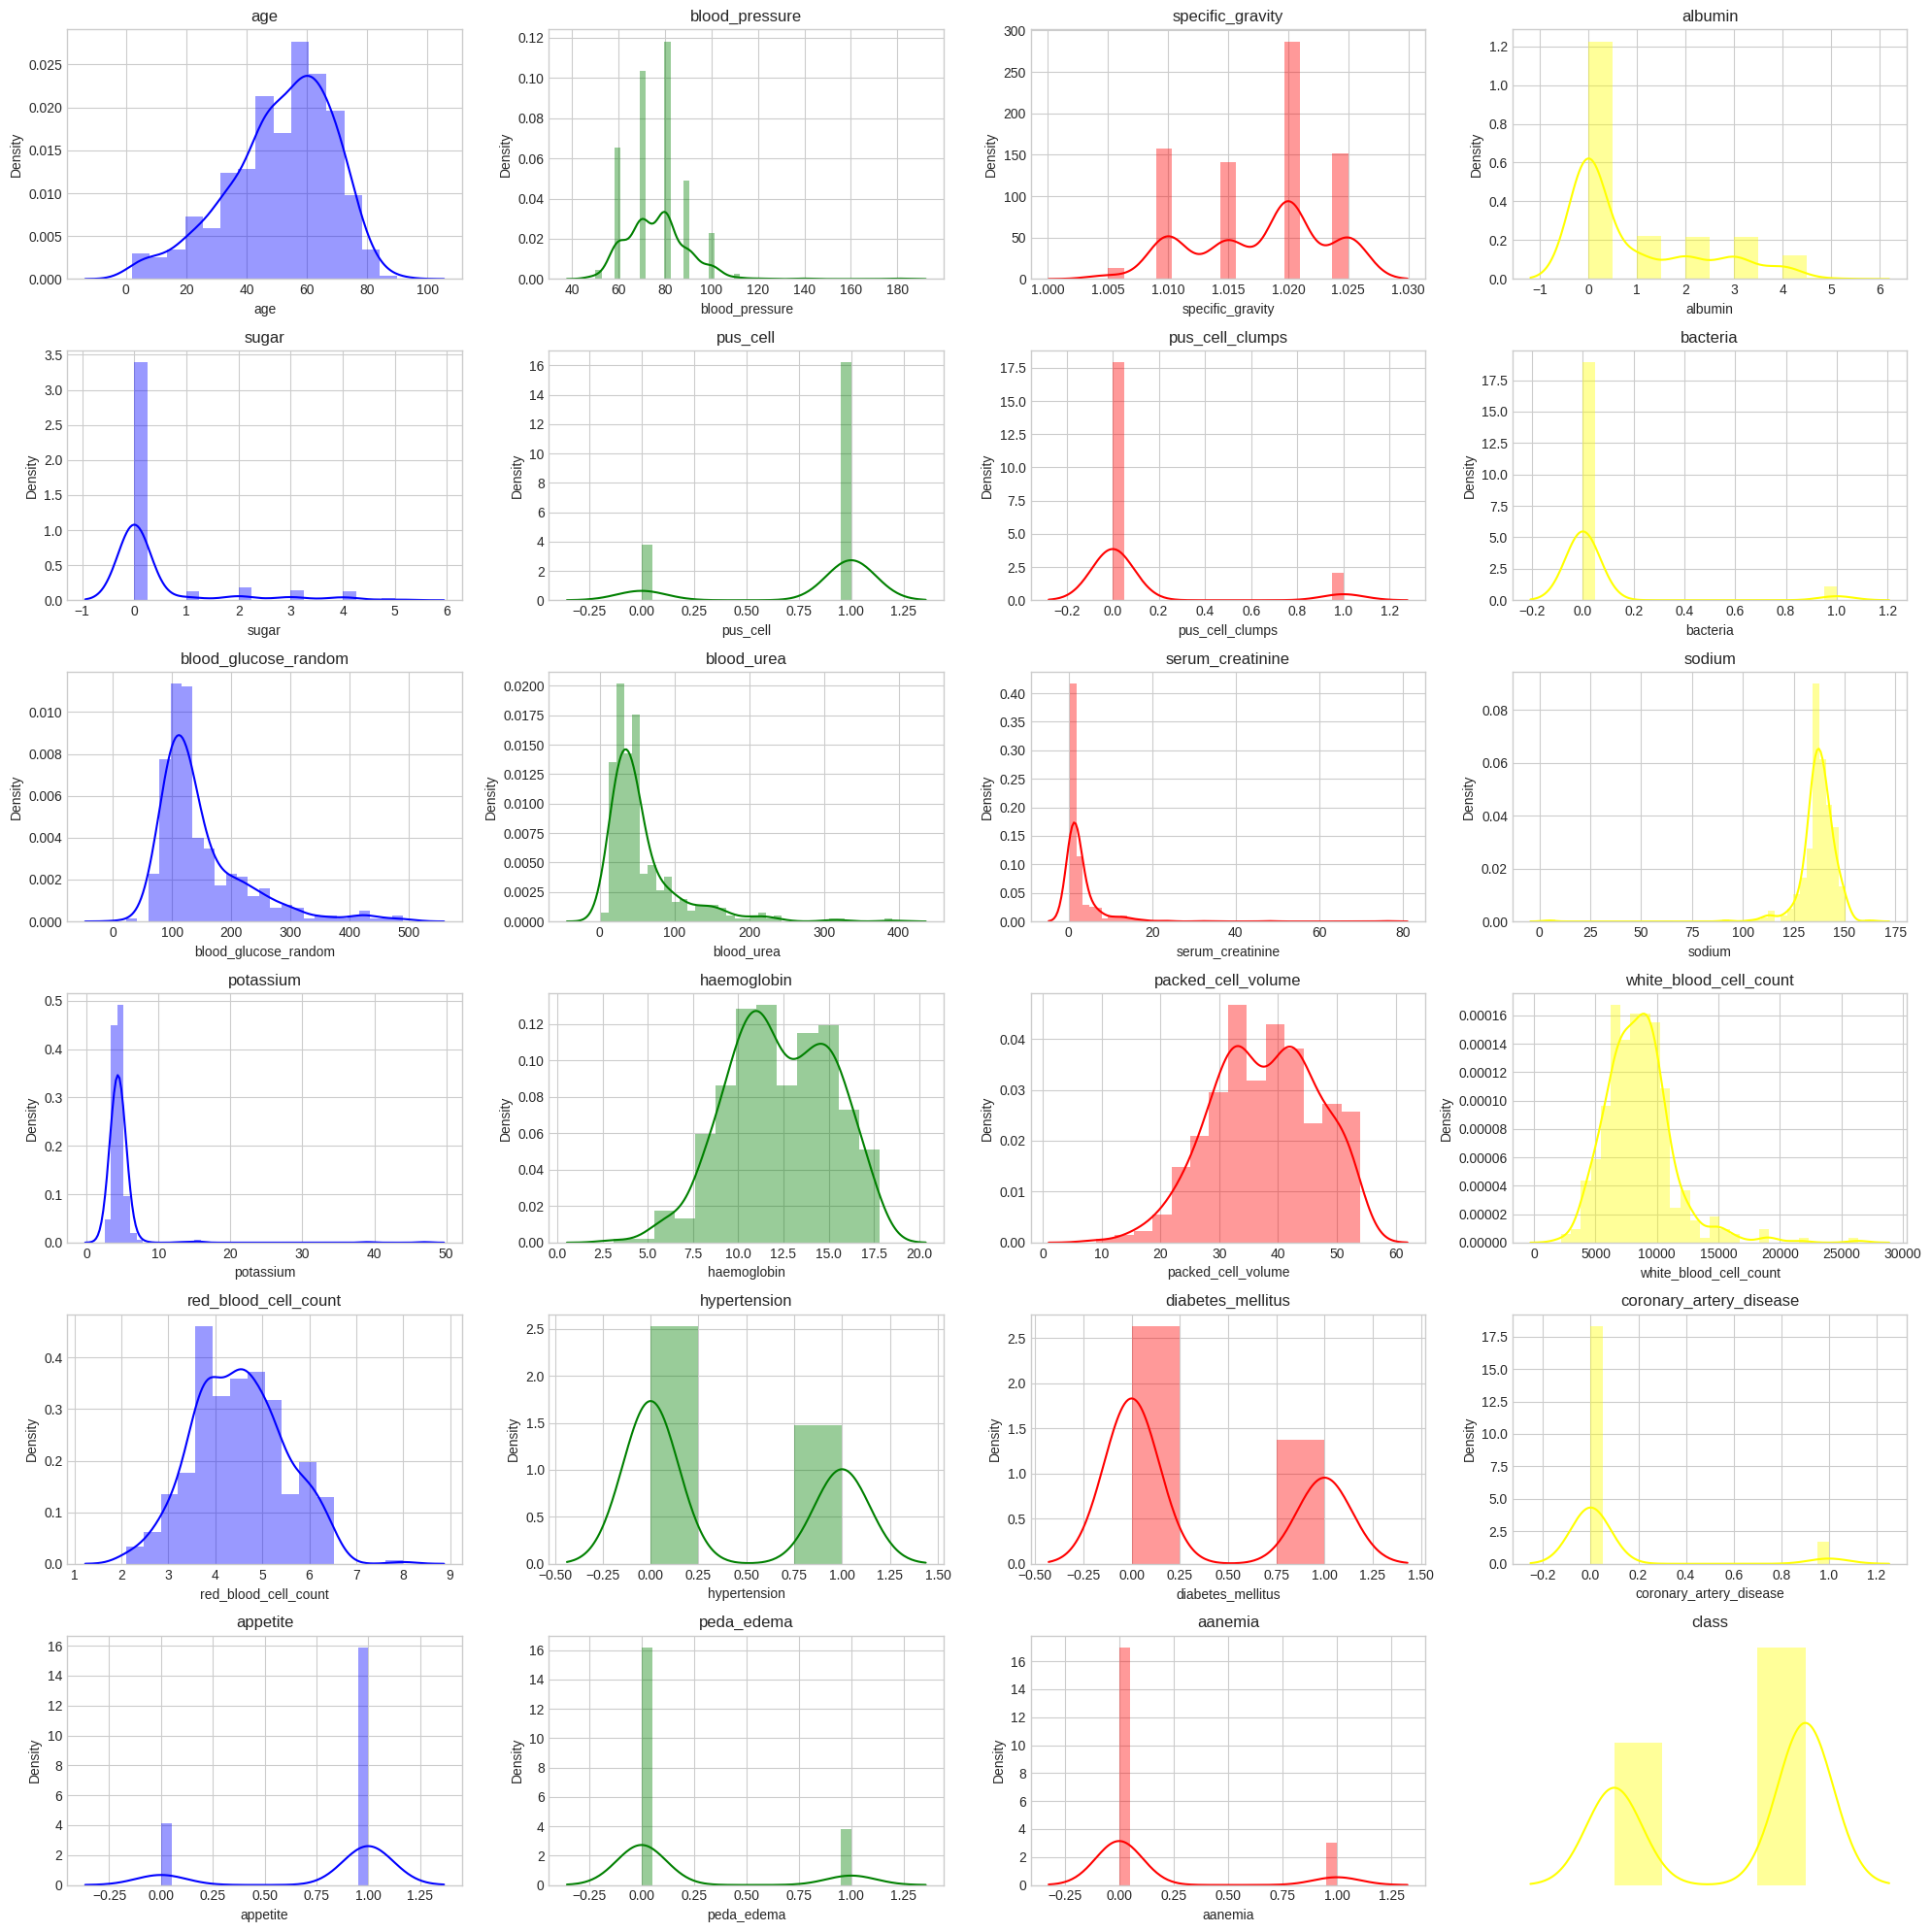

In [26]:
n_rows = 6
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize = (20, 20))
axes = axes.flatten()

color = ['blue', 'green', 'red', 'yellow']

for index, column in enumerate(data.columns):
  ax = axes[index]
  sns.distplot(data[column], ax = ax, color=color[index%4])
  ax.set_title(column)
plt.tight_layout()
plt.axis(False);

Considerable amount of data imbalance can be observed from the data representations.

```
Columns: ['bacteria', 'pus_cell_clumps', 'coronary_artery_disease', 'anaemia', 'appetite', 'peda_edema']
```

<Axes: xlabel='class', ylabel='Density'>

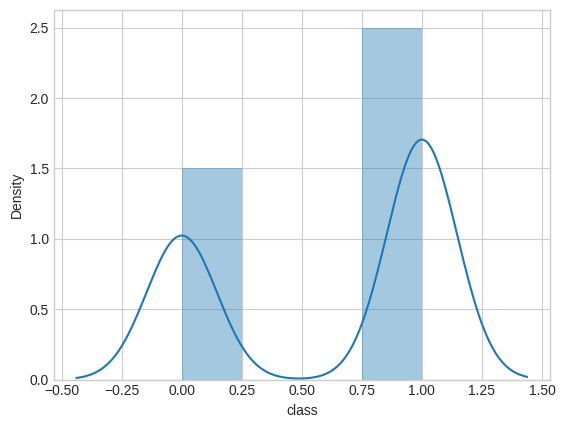

In [27]:
sns.distplot(data['class'])

No class imbalance, since the ratio of the classes is about 2.5: 1.5

<Axes: >

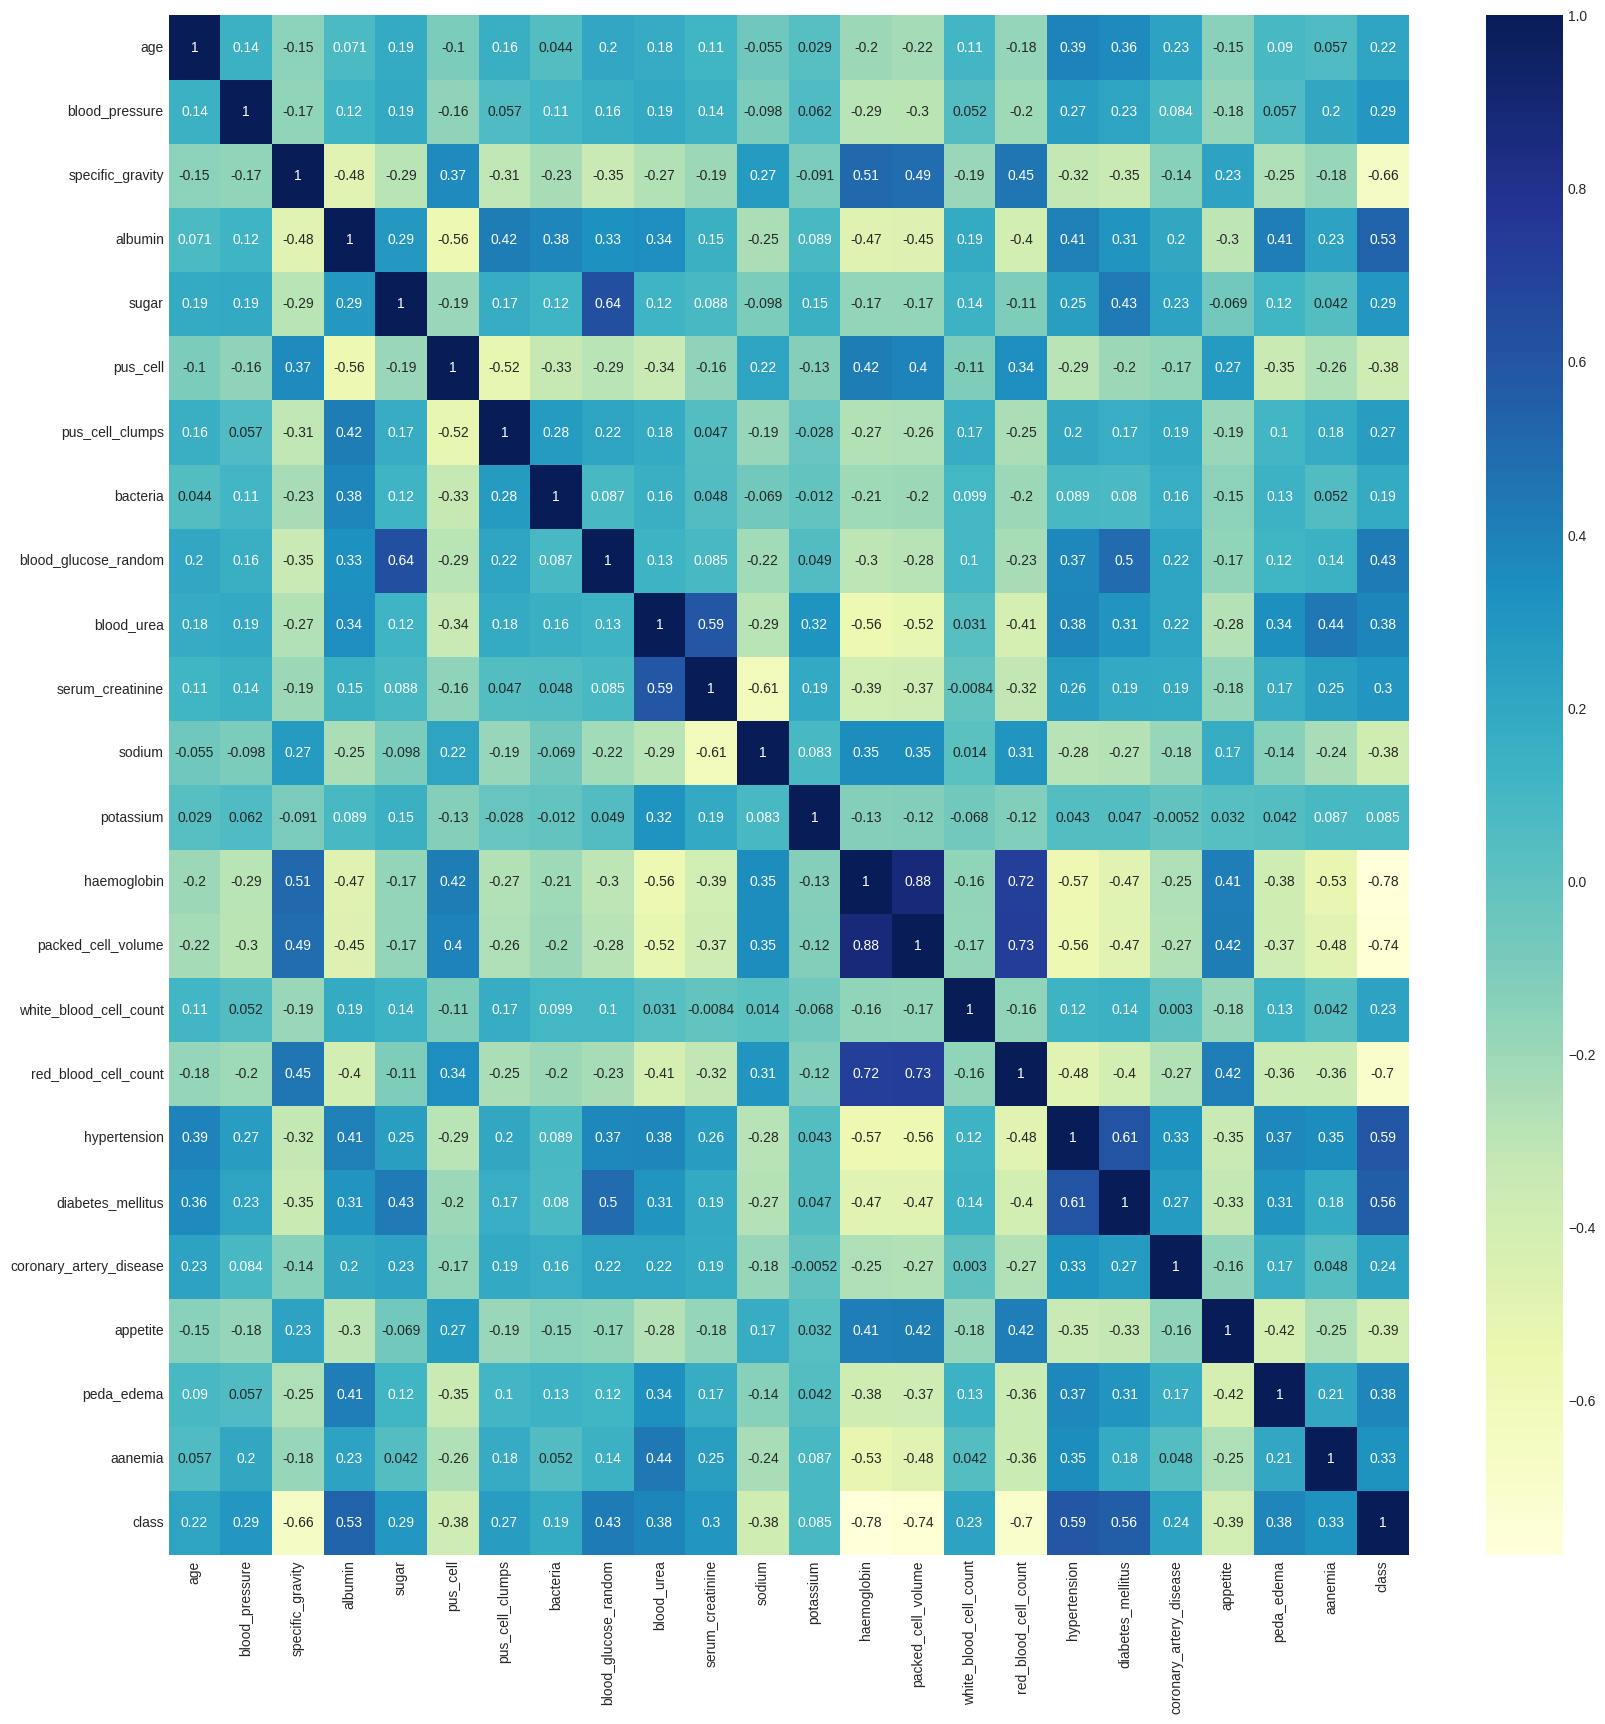

In [28]:
# Create a correlation matrix
corr = data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap="YlGnBu", annot=True)

#### Removing data imbalance in the independent variables of the data

In [29]:
# Remove columns with high correlation
cols_to_remove = ['red_blood_cell_count', 'haemoglobin', 'blood_urea', 'packed_cell_volume', 'specific_gravity']

data_prp = data.copy()

# Remove the columns
data_prp.drop(cols_to_remove, axis=1, inplace=True)

<Axes: >

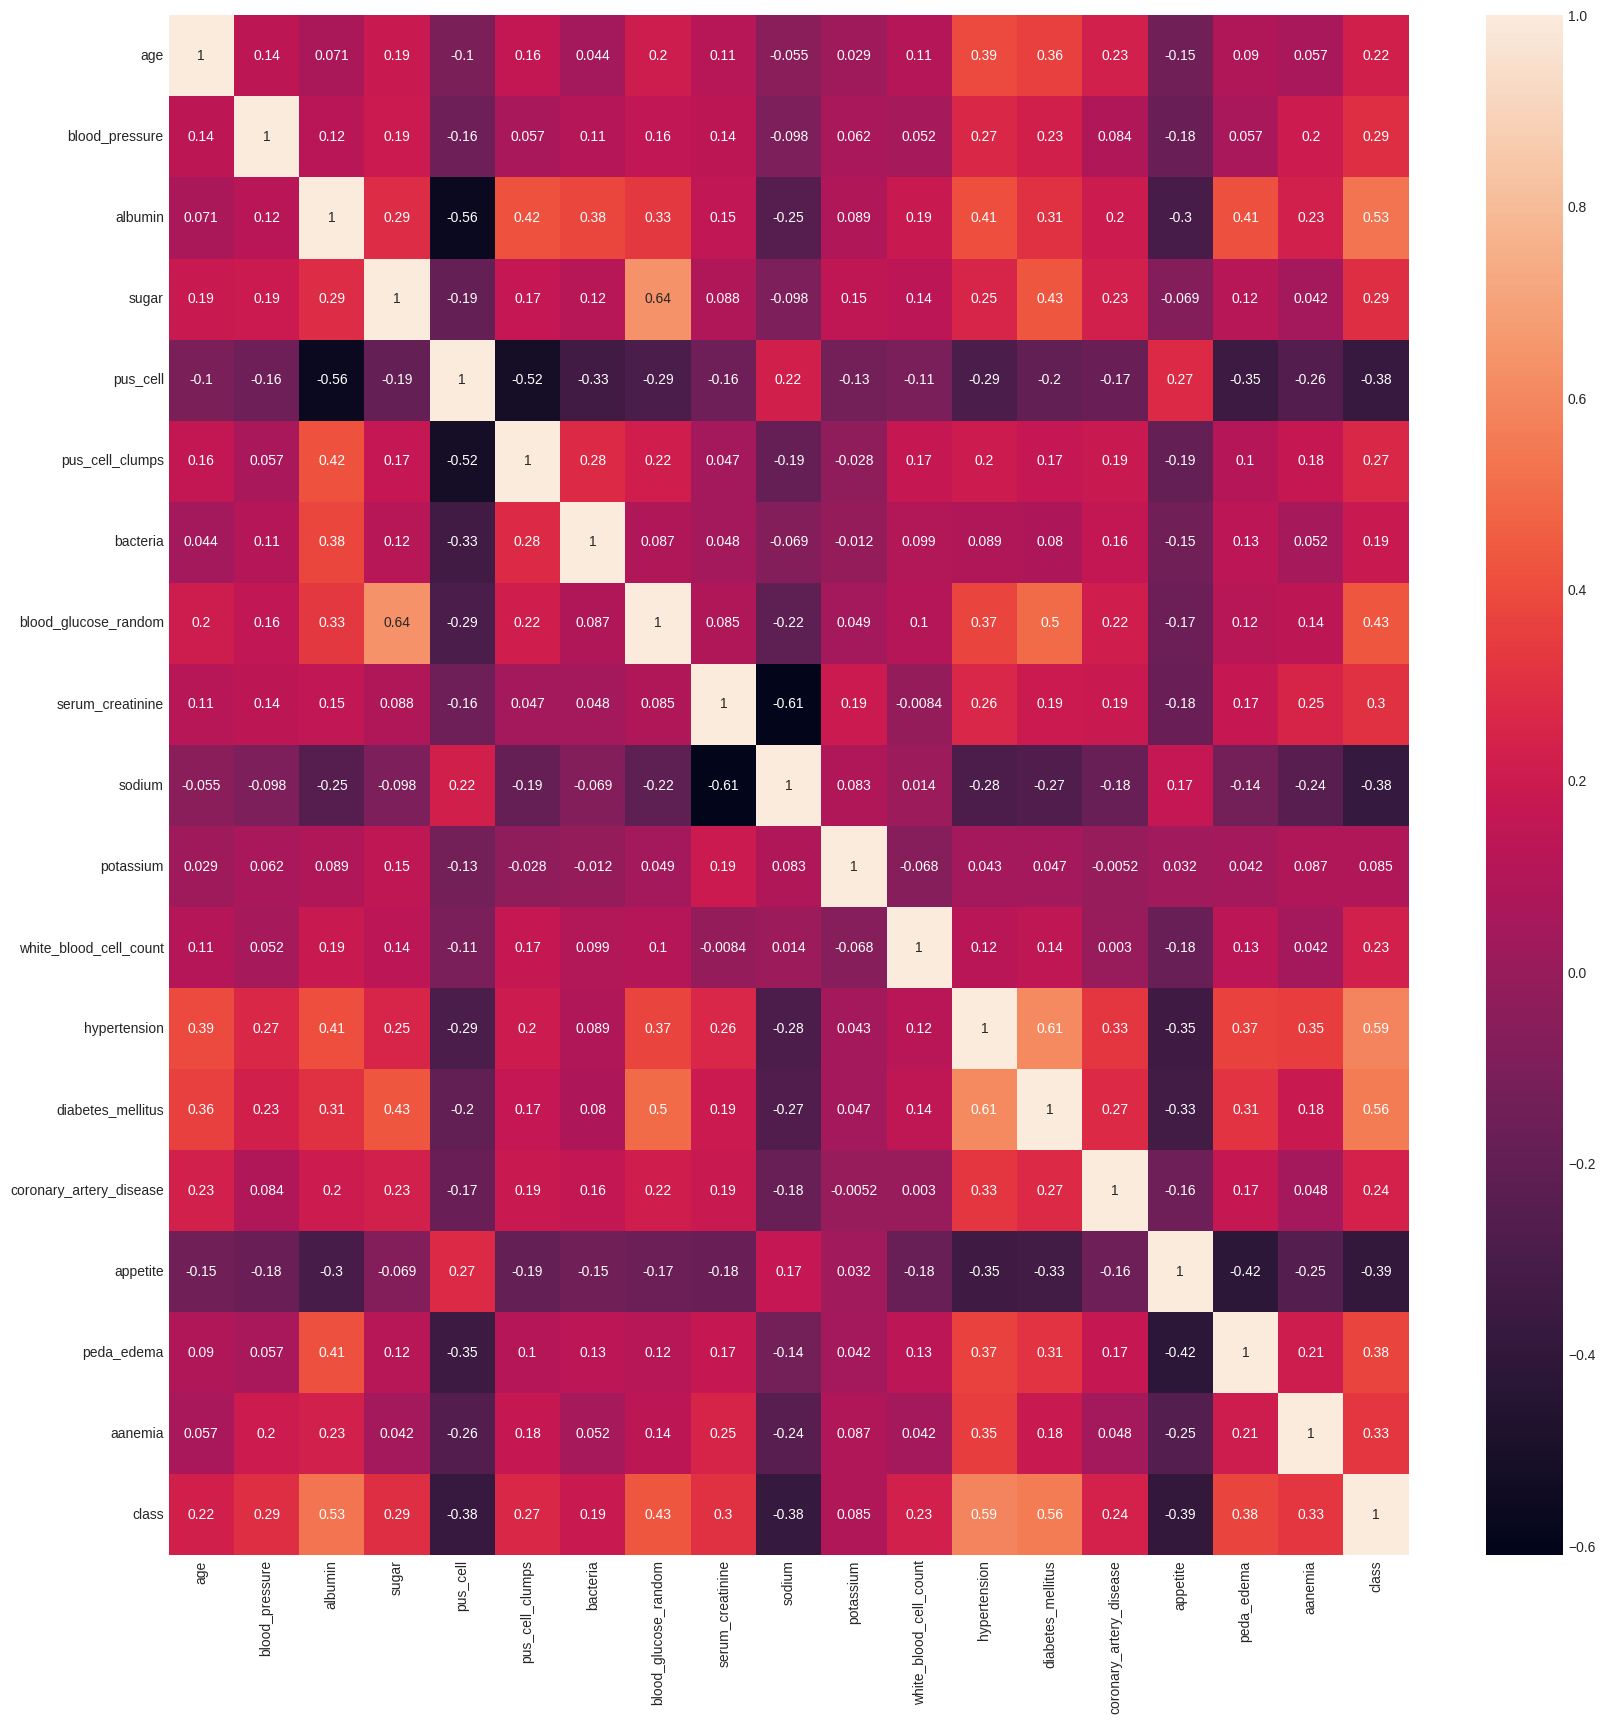

In [30]:
# Create the heatmap
corr = data_prp.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot = True)

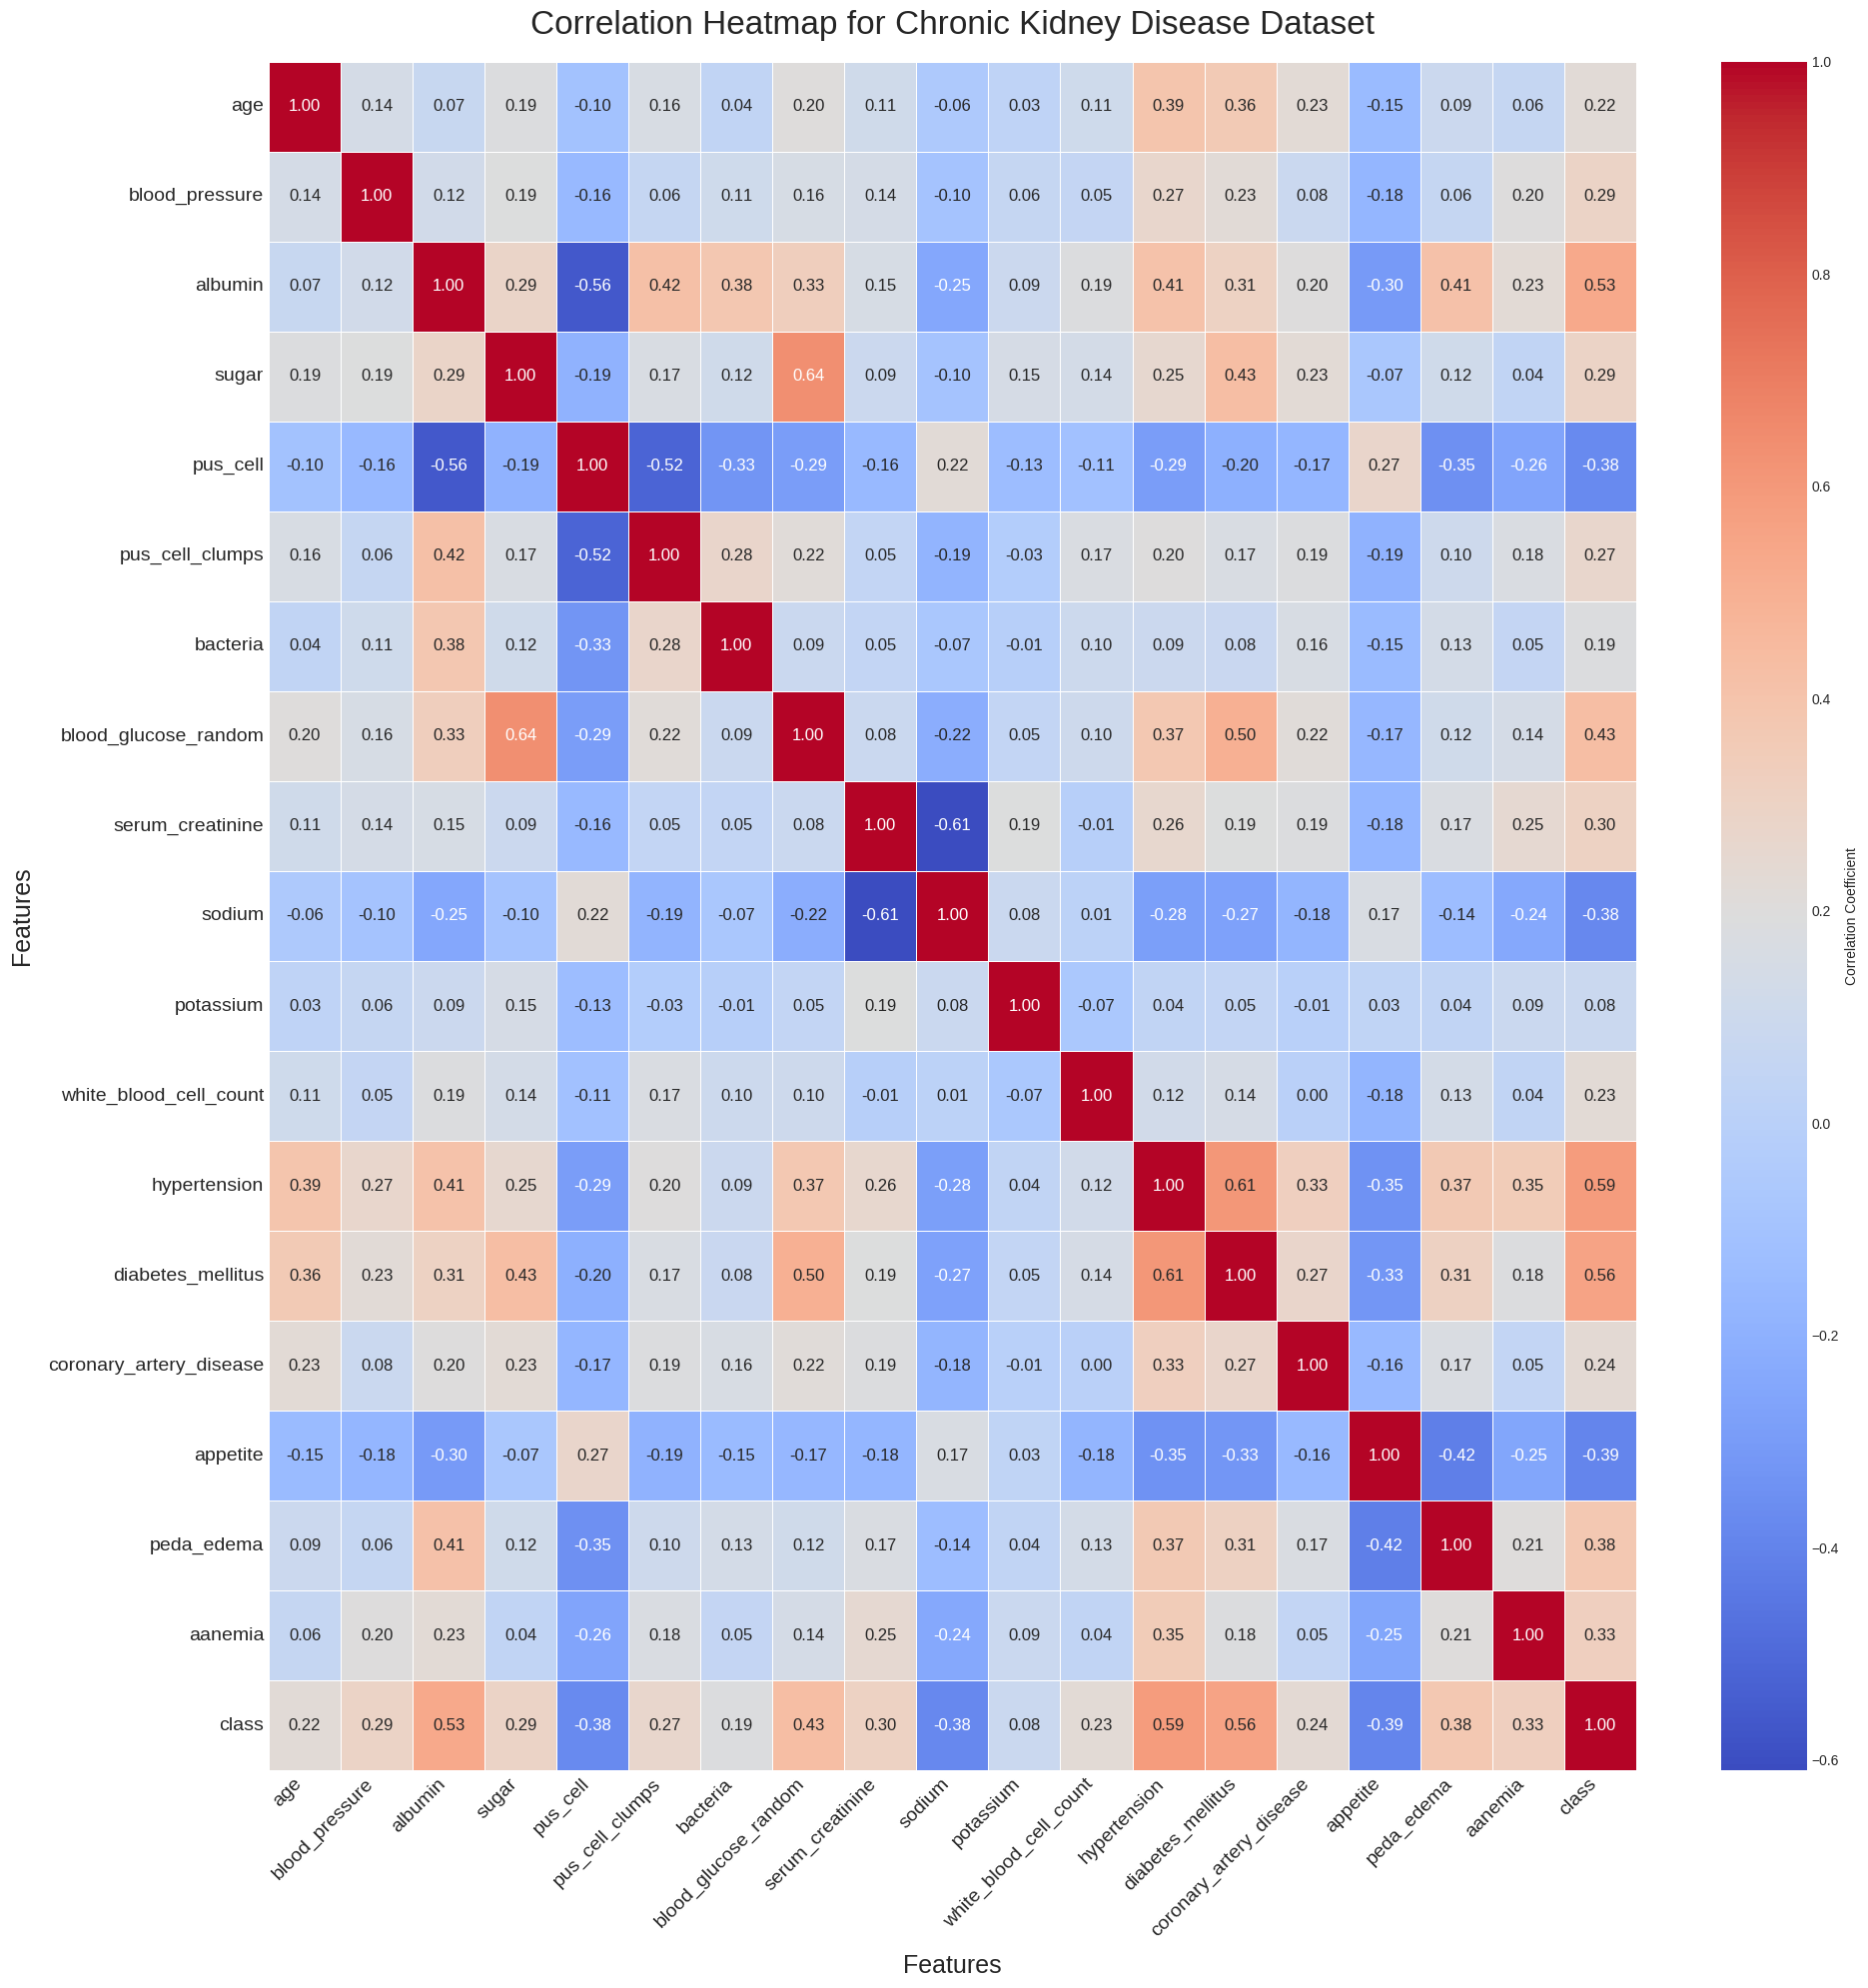

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data_prp' is your DataFrame containing the chronic kidney disease dataset
corr = data_prp.corr()

# Create a figure and a set of subplots with a specified size
plt.figure(figsize=(20, 20))

# Create the heatmap with additional customizations
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'},
            annot_kws={"size": 12}, linewidths=.5, fmt='.2f')

# Add a title and labels to the heatmap
plt.title('Correlation Heatmap for Chronic Kidney Disease Dataset', fontsize=24, pad=20)
plt.xlabel('Features', fontsize=18, labelpad=10)
plt.ylabel('Features', fontsize=18, labelpad=10)

# Adjust the tick labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Adjust the layout to make room for the rotated x-axis labels
plt.tight_layout()

# Show the heatmap
plt.show()


#### Normalize and standardize the both the data

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
ms = MinMaxScaler()
ss = StandardScaler()

In [33]:
# First, split to dependendent and independent variables
X_feat = data_prp.drop('class', axis=1)
y_feat = data_prp['class']

In [34]:
# Normalize the data
X_feat_norm = ms.fit_transform(X_feat)
X_feat_norm

array([[0.52272727, 0.23076923, 0.2       , ..., 1.        , 0.        ,
        0.        ],
       [0.05681818, 0.        , 0.8       , ..., 1.        , 0.        ,
        0.        ],
       [0.68181818, 0.23076923, 0.4       , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.11363636, 0.23076923, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.17045455, 0.07692308, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.63636364, 0.23076923, 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [35]:
# Standardize the data
X_feat_std = ss.fit_transform(X_feat)
X_feat_std

array([[-0.20118228,  0.25421378,  0.07624929, ...,  0.50780078,
        -0.4843221 , -0.42008403],
       [-2.59638331, -1.97247624,  2.36372784, ...,  0.50780078,
        -0.4843221 , -0.42008403],
       [ 0.61669124,  0.25421378,  0.83874214, ..., -1.96927621,
        -0.4843221 ,  2.38047614],
       ...,
       [-2.30428562,  0.25421378, -0.68624357, ...,  0.50780078,
        -0.4843221 , -0.42008403],
       [-2.01218794, -1.23024623, -0.68624357, ...,  0.50780078,
        -0.4843221 , -0.42008403],
       [ 0.38301309,  0.25421378, -0.68624357, ...,  0.50780078,
        -0.4843221 , -0.42008403]])

#### Split the data into train and test splits

In [36]:
from sklearn.model_selection import train_test_split

# With feature selection
X_train, X_test, y_train, y_test = train_test_split(X_feat, y_feat, random_state=42, test_size = 0.23)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_feat_norm, y_feat, random_state=42, test_size = 0.23)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_feat_std, y_feat, random_state=42, test_size = 0.23)

### Initiating the models for training

In [37]:
# Making a set of models
model_lst = {
    "Logistic_Regression": LogisticRegression(),
    "Decision_Tree_Classifier": DecisionTreeClassifier(),
    "Random_Forest_Classifier": RandomForestClassifier(),
    "AdaBoost_Classifier": AdaBoostClassifier(),
    "XGBoost_Classifier": XGBClassifier(objective='binary:logistic', seed=42, verbosity=0),
    "LightBGM_Classifier": lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42),
    "Catboost_Classifier": CatBoostClassifier(),
    "ExtraTree_Classifier": ExtraTreesClassifier()
}

In [38]:
# Making a stacking classifier as well for modelling (bagging-tree-intensive)
estimators = [
    ('et', ExtraTreesClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier())
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier()
)

model_lst["Stacking_Classifier_1"] = stacking_clf

In [39]:
# Making a stacking classifier as well for modelling (boosting-intensive)
estimators = [
    ('xgb', XGBClassifier(objective='binary:logistic', seed=42, verbosity=0)),
    ('lgb', lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)),
    ('rf', CatBoostClassifier())
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(objective='binary:logistic', seed=42, verbosity=0)
)

model_lst["Stacking_Classifier_2"] = stacking_clf

In [40]:
# Hyperparameter grids for each classifier
param_grid = {
    "Logistic_Regression": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    },
    "Decision_Tree_Classifier": {
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 3, 5, 7, 9, 10],
        'min_samples_leaf': [1, 2, 4, 8, 16],
        'max_features': ['auto', 'sqrt', 'log2', None]
    },
    "Random_Forest_Classifier": {
        'n_estimators': [50, 100],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 3],
        'min_samples_leaf': [1, 2],
        'max_features': ['log2', 'sqrt']
    },
    "AdaBoost_Classifier": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.001, 0.01, 0.1, 1, 10]
    },
    "ExtraTree_Classifier":{
        'n_estimators': [100, 200],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [20, 40],
        'min_samples_split': [2, 7],
    },
    "Stacking_Classifier_1": {},
    "Stacking_Classifier_2": {},
    "XGBoost_Classifier": {},
    "LightBGM_Classifier": {},
    "Catboost_Classifier": {}
}

In [41]:
# Making a function to train, test and evaluate multiple models in one-go
def train_test_score_model(model_lst: dict, train_data: tuple,
                           test_data: tuple, target_names: list,
                           return_data: bool = True,
                           if_std: bool = False, if_nm: bool = False):

    model_res = {}

    X_train, y_train = train_data[0], train_data[1]
    X_test, y_test = test_data[0], test_data[1]

    # Iterate through each of the models
    for model_i in model_lst:
        model = model_lst[model_i]

        # Perform grid search cross validation on model using param_grid
        grid_search = GridSearchCV(estimator = model, param_grid = param_grid[model_i],
                                   cv=5)

        grid_search.fit(X_train, y_train) # Train model

        # Get the best hyperparameters and model
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        if if_std:
          model_i += '_std'

        if if_nm:
          model_i += '_norm'

        # Append the best model to the dict
        model_res[model_i] = {"model": best_model}

        # Fit the model to training data
        best_model.fit(X_train, y_train)

        # Make predictions using the trained model
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Get the prediction probabilities
        y_pred_probs = best_model.predict_proba(X_test)
        model_res[model_i]['pred_probs'] = y_pred_probs

        # Get the accuracy scores of the model on the train and test sets
        y_train_accuracy_score = accuracy_score(y_train, y_train_pred)
        y_test_accuracy_score = accuracy_score(y_test, y_test_pred)

        # Get the classification report for each model
        cls_report = classification_report(y_test, y_test_pred, target_names = target_names)

        # Save the classification report as dictionary
        cls_report_dict = classification_report(y_test, y_test_pred, target_names = target_names, output_dict=True)
        model_res[model_i]['class_report'] = cls_report_dict

        # Append the predictions and accuracy scores of each model to the model prediction list
        model_res[model_i]['train_acc'] = y_train_accuracy_score
        model_res[model_i]['test_acc'] = y_test_accuracy_score

        model_res[model_i]['predictions'] = y_test_pred

        # Print the scores evaluated using after predictions
        print(model_i)
        print("-"*len(model_i))
        print('Model performance for Train and test sets')
        print("- Training set accuracy score: {:.4f}".format(y_train_accuracy_score))
        print("- Test set accuracy score: {:.4f}".format(y_test_accuracy_score))
        print(f"Classification report:\n {cls_report}")
        print("-------------------------------------------------------------------------")
        print()

    if return_data:
        return model_res

### Training the models

#### Training on normal data

In [42]:
model_res = train_test_score_model(
    model_lst,
    train_data = (X_train, y_train),
    test_data = (X_test, y_test),
    target_names = ["not_ckd", "ckd"],
    return_data = True
)

Streaming output truncated to the last 5000 lines.
21:	learn: 0.5376526	total: 45.5ms	remaining: 2.02s
22:	learn: 0.5326875	total: 47.1ms	remaining: 2s
23:	learn: 0.5270529	total: 48.8ms	remaining: 1.98s
24:	learn: 0.5217583	total: 51.2ms	remaining: 2s
25:	learn: 0.5160710	total: 53.2ms	remaining: 1.99s
26:	learn: 0.5108285	total: 55.2ms	remaining: 1.99s
27:	learn: 0.5045061	total: 56.9ms	remaining: 1.97s
28:	learn: 0.4994888	total: 58.6ms	remaining: 1.96s
29:	learn: 0.4937599	total: 59.8ms	remaining: 1.94s
30:	learn: 0.4882286	total: 61.5ms	remaining: 1.92s
31:	learn: 0.4826504	total: 63.3ms	remaining: 1.91s
32:	learn: 0.4771011	total: 65.3ms	remaining: 1.91s
33:	learn: 0.4721785	total: 67ms	remaining: 1.9s
34:	learn: 0.4665440	total: 68.3ms	remaining: 1.88s
35:	learn: 0.4618619	total: 70.3ms	remaining: 1.88s
36:	learn: 0.4565101	total: 72ms	remaining: 1.88s
37:	learn: 0.4513719	total: 73.9ms	remaining: 1.87s
38:	learn: 0.4463597	total: 75.2ms	remaining: 1.85s
39:	learn: 0.4412156	tot

In [43]:
model_res.keys()

dict_keys(['Logistic_Regression', 'Decision_Tree_Classifier', 'Random_Forest_Classifier', 'AdaBoost_Classifier', 'XGBoost_Classifier', 'LightBGM_Classifier', 'Catboost_Classifier', 'ExtraTree_Classifier', 'Stacking_Classifier_1', 'Stacking_Classifier_2'])

#### Training on normalized data

In [44]:
model_res_norm = train_test_score_model(
    model_lst,
    train_data = (X_train_norm, y_train),
    test_data = (X_test_norm, y_test),
    target_names = ["not_ckd", "ckd"],
    return_data = True,
    if_nm = True
)

Streaming output truncated to the last 5000 lines.
21:	learn: 0.5376526	total: 80.9ms	remaining: 3.6s
22:	learn: 0.5326875	total: 83.5ms	remaining: 3.55s
23:	learn: 0.5270529	total: 88ms	remaining: 3.58s
24:	learn: 0.5217583	total: 92.1ms	remaining: 3.59s
25:	learn: 0.5160710	total: 95.9ms	remaining: 3.59s
26:	learn: 0.5108285	total: 99.7ms	remaining: 3.59s
27:	learn: 0.5045061	total: 103ms	remaining: 3.59s
28:	learn: 0.4994888	total: 108ms	remaining: 3.63s
29:	learn: 0.4937599	total: 111ms	remaining: 3.58s
30:	learn: 0.4882286	total: 116ms	remaining: 3.63s
31:	learn: 0.4826504	total: 119ms	remaining: 3.59s
32:	learn: 0.4771011	total: 123ms	remaining: 3.6s
33:	learn: 0.4721785	total: 127ms	remaining: 3.6s
34:	learn: 0.4665440	total: 130ms	remaining: 3.59s
35:	learn: 0.4618619	total: 133ms	remaining: 3.55s
36:	learn: 0.4565101	total: 135ms	remaining: 3.51s
37:	learn: 0.4513719	total: 137ms	remaining: 3.47s
38:	learn: 0.4463597	total: 138ms	remaining: 3.4s
39:	learn: 0.4412156	total: 140

In [45]:
model_res_norm

{'Logistic_Regression_norm': {'model': LogisticRegression(C=100),
  'pred_probs': array([[5.71148894e-01, 4.28851106e-01],
         [9.23017258e-01, 7.69827420e-02],
         [3.43015172e-10, 1.00000000e+00],
         [5.81756865e-14, 1.00000000e+00],
         [2.22044605e-15, 1.00000000e+00],
         [2.81996648e-14, 1.00000000e+00],
         [9.86330197e-01, 1.36698028e-02],
         [3.14332232e-02, 9.68566777e-01],
         [8.34292461e-01, 1.65707539e-01],
         [1.71598291e-10, 1.00000000e+00],
         [1.64313008e-14, 1.00000000e+00],
         [9.68717345e-01, 3.12826547e-02],
         [0.00000000e+00, 1.00000000e+00],
         [7.54951657e-14, 1.00000000e+00],
         [5.52083690e-09, 9.99999994e-01],
         [1.20322616e-04, 9.99879677e-01],
         [9.41360589e-01, 5.86394105e-02],
         [9.66143821e-01, 3.38561794e-02],
         [3.28458549e-09, 9.99999997e-01],
         [9.63102199e-01, 3.68978008e-02],
         [1.39300825e-07, 9.99999861e-01],
         [9.63520

#### Training on standardized data

In [46]:
model_res_std = train_test_score_model(
    model_lst,
    train_data = (X_train_std, y_train),
    test_data = (X_test_std, y_test),
    target_names = ["not_ckd", "ckd"],
    return_data = True,
    if_std = True
)

Streaming output truncated to the last 5000 lines.
21:	learn: 0.5376526	total: 49.5ms	remaining: 2.2s
22:	learn: 0.5326875	total: 52.9ms	remaining: 2.25s
23:	learn: 0.5270529	total: 56.9ms	remaining: 2.31s
24:	learn: 0.5217583	total: 62.5ms	remaining: 2.44s
25:	learn: 0.5160710	total: 65.4ms	remaining: 2.45s
26:	learn: 0.5108285	total: 66.9ms	remaining: 2.41s
27:	learn: 0.5045061	total: 68.7ms	remaining: 2.38s
28:	learn: 0.4994888	total: 70.5ms	remaining: 2.36s
29:	learn: 0.4937599	total: 72ms	remaining: 2.33s
30:	learn: 0.4882286	total: 73.8ms	remaining: 2.31s
31:	learn: 0.4826504	total: 75.7ms	remaining: 2.29s
32:	learn: 0.4771011	total: 77.5ms	remaining: 2.27s
33:	learn: 0.4721785	total: 79.3ms	remaining: 2.25s
34:	learn: 0.4665440	total: 80.6ms	remaining: 2.22s
35:	learn: 0.4618619	total: 82.4ms	remaining: 2.21s
36:	learn: 0.4565101	total: 84.1ms	remaining: 2.19s
37:	learn: 0.4513719	total: 85.9ms	remaining: 2.17s
38:	learn: 0.4463597	total: 87.2ms	remaining: 2.15s
39:	learn: 0.441

In [47]:
model_res_std

{'Logistic_Regression_std': {'model': LogisticRegression(C=100),
  'pred_probs': array([[4.78298914e-03, 9.95217011e-01],
         [9.86630523e-01, 1.33694773e-02],
         [3.77475828e-15, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [9.98944806e-01, 1.05519358e-03],
         [1.65429610e-02, 9.83457039e-01],
         [8.13015577e-01, 1.86984423e-01],
         [6.66133815e-16, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [9.97154300e-01, 2.84569954e-03],
         [0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [8.39524689e-05, 9.99916048e-01],
         [9.68546369e-01, 3.14536309e-02],
         [9.95274241e-01, 4.72575937e-03],
         [9.14601728e-13, 1.00000000e+00],
         [9.98699072e-01, 1.30092778e-03],
         [8.23439095e-11, 1.00000000e+00],
         [0.000000

#### Now, creating a voting classifier using the best 5 distinct models

##### Getting the sorted model information

In [48]:
# Initialize lists to store model metrics
model_name = []
train_acc = []
test_acc = []
macro_precision = []
macro_recall = []
macro_f1_score = []

# Iterate over each model in the dictionary
for name, details in (model_res | model_res_norm | model_res_std).items():
    model_name.append(name)
    train_acc.append(details['train_acc'])
    test_acc.append(details['test_acc'])

    cls_rep = details['class_report']

    # Extract macro averaged precision, recall, and f1-score
    macro_precision.append(cls_rep['macro avg']['precision'])
    macro_recall.append(cls_rep['macro avg']['recall'])
    macro_f1_score.append(cls_rep['macro avg']['f1-score'])

# Create dataframe
df = pd.DataFrame({
    'model_name': model_name,
    'model_train_accuracy': train_acc,
    'model_test_accuracy': test_acc,
    'model_macro_avg_precision': macro_precision,
    'model_macro_avg_recall': macro_recall,
    'model_macro_avg_f1_score': macro_f1_score
})

In [49]:
df

model_name  model_train_accuracy  model_test_accuracy  \
0             Logistic_Regression              0.980519             0.945652   
1        Decision_Tree_Classifier              0.987013             0.989130   
2        Random_Forest_Classifier              1.000000             0.978261   
3             AdaBoost_Classifier              0.996753             0.967391   
4              XGBoost_Classifier              1.000000             0.945652   
5             LightBGM_Classifier              1.000000             0.945652   
6             Catboost_Classifier              1.000000             0.967391   
7            ExtraTree_Classifier              1.000000             1.000000   
8           Stacking_Classifier_1              1.000000             1.000000   
9           Stacking_Classifier_2              1.000000             0.967391   
10       Logistic_Regression_norm              0.977273             0.978261   
11  Decision_Tree_Classifier_norm              1.000000             0.989130   
12  Random_Forest_Classifier_norm              1.000000             0.967391   
13       AdaBoost_Classifier_norm              0.996753             0.967391   
14        XGBoost_Classifier_norm              1.000000             0.945652   
15       LightBGM_Classifier_norm              1.000000             0.956522   
16       Catboost_Classifier_norm              1.000000             0.967391   
17      ExtraTree_Classifier_norm              1.000000             1.000000   
18     Stacking_Classifier_1_norm              1.000000             1.000000   
19     Stacking_Classifier_2_norm              1.000000             0.978261   
20        Logistic_Regression_std              0.990260             0.989130   
21   Decision_Tree_Classifier_std              1.000000             0.956522   
22   Random_Forest_Classifier_std              1.000000             0.978261   
23        AdaBoost_Classifier_std              0.996753             0.967391   
24         XGBoost_Classifier_std              1.000000             0.945652   
25        LightBGM_Classifier_std              1.000000             0.956522   
26        Catboost_Classifier_std              1.000000             0.967391   
27       ExtraTree_Classifier_std              1.000000             1.000000   
28      Stacking_Classifier_1_std              1.000000             1.000000   
29      Stacking_Classifier_2_std              1.000000             0.978261   

    model_macro_avg_precision  model_macro_avg_recall  \
0                    0.937596                0.943750   
1                    0.984848                0.991667   
2                    0.970588                0.983333   
3                    0.957143                0.975000   
4                    0.937596                0.943750   
5                    0.937596                0.943750   
6                    0.957143                0.975000   
7                    1.000000                1.000000   
8                    1.000000                1.000000   
9                    0.957143                0.975000   
10                   0.976042                0.976042   
11                   0.984848                0.991667   
12                   0.961222                0.967708   
13                   0.957143                0.975000   
14                   0.937596                0.943750   
15                   0.947262                0.959375   
16                   0.957143                0.975000   
17                   1.000000                1.000000   
18                   1.000000                1.000000   
19                   0.970588                0.983333   
20                   0.991803                0.984375   
21                   0.952083                0.952083   
22                   0.970588                0.983333   
23                   0.957143                0.975000   
24                   0.937596                0.943750   
25                   0.947262                0.959375   
26 

In [50]:
# Sort the DataFrame by all parameters except 'model_name' with appropriate ascending/descending
df_sorted = df.sort_values(by=['model_train_accuracy',
                               'model_test_accuracy',
                               'model_macro_avg_precision',
                               'model_macro_avg_recall',
                               'model_macro_avg_f1_score'],
                           ascending=[False, False, False, False, False])

# Display the sorted DataFrame
df_sorted

model_name  model_train_accuracy  model_test_accuracy  \
7            ExtraTree_Classifier              1.000000             1.000000   
8           Stacking_Classifier_1              1.000000             1.000000   
17      ExtraTree_Classifier_norm              1.000000             1.000000   
18     Stacking_Classifier_1_norm              1.000000             1.000000   
27       ExtraTree_Classifier_std              1.000000             1.000000   
28      Stacking_Classifier_1_std              1.000000             1.000000   
11  Decision_Tree_Classifier_norm              1.000000             0.989130   
2        Random_Forest_Classifier              1.000000             0.978261   
19     Stacking_Classifier_2_norm              1.000000             0.978261   
22   Random_Forest_Classifier_std              1.000000             0.978261   
29      Stacking_Classifier_2_std              1.000000             0.978261   
12  Random_Forest_Classifier_norm              1.000000             0.967391   
6             Catboost_Classifier              1.000000             0.967391   
9           Stacking_Classifier_2              1.000000             0.967391   
16       Catboost_Classifier_norm              1.000000             0.967391   
26        Catboost_Classifier_std              1.000000             0.967391   
21   Decision_Tree_Classifier_std              1.000000             0.956522   
15       LightBGM_Classifier_norm              1.000000             0.956522   
25        LightBGM_Classifier_std              1.000000             0.956522   
4              XGBoost_Classifier              1.000000             0.945652   
5             LightBGM_Classifier              1.000000             0.945652   
14        XGBoost_Classifier_norm              1.000000             0.945652   
24         XGBoost_Classifier_std              1.000000             0.945652   
3             AdaBoost_Classifier              0.996753             0.967391   
13       AdaBoost_Classifier_norm              0.996753             0.967391   
23        AdaBoost_Classifier_std              0.996753             0.967391   
20        Logistic_Regression_std              0.990260             0.989130   
1        Decision_Tree_Classifier              0.987013             0.989130   
0             Logistic_Regression              0.980519             0.945652   
10       Logistic_Regression_norm              0.977273             0.978261   

    model_macro_avg_precision  model_macro_avg_recall  \
7                    1.000000                1.000000   
8                    1.000000                1.000000   
17                   1.000000                1.000000   
18                   1.000000                1.000000   
27                   1.000000                1.000000   
28                   1.000000                1.000000   
11                   0.984848                0.991667   
2                    0.970588                0.983333   
19                   0.970588                0.983333   
22                   0.970588                0.983333   
29                   0.970588                0.983333   
12                   0.961222                0.967708   
6                    0.957143                0.975000   
9                    0.957143                0.975000   
16                   0.957143                0.975000   
26                   0.957143                0.975000   
21                   0.952083                0.952083   
15                   0.947262                0.959375   
25                   0.947262                0.959375   
4                    0.937596                0.943750   
5                    0.937596                0.943750   
14                   0.937596                0.943750   
24                   0.937596                0.943750   
3                    0.957143                0.975000   
13                   0.957143                0.975000   
23                   0.957143                0.975000   
20 

#### Creating a voting classifier

##### Using the ensemble models only

In [51]:
from sklearn.ensemble import VotingClassifier

# Create ensemble
ensemble_1 = VotingClassifier(estimators=[
    ('AdaBoost classifier', model_res['AdaBoost_Classifier']['model']),
    ('Stacking_Classifier', model_res['Stacking_Classifier_1']['model']),
    ('Random forest classifier (std data)', model_res_std['Random_Forest_Classifier_std']['model']),
    ('Decision Tree classifier (std data)', model_res_std['Decision_Tree_Classifier_std']['model']),
    ('Logistic regression (nm data)', model_res_norm['Logistic_Regression_norm']['model'])
], voting='soft')  # 'hard' voting for classification

# Train ensemble
ensemble_1.fit(X_train, y_train)

VotingClassifier(estimators=[('AdaBoost classifier',
                              AdaBoostClassifier(learning_rate=0.1)),
                             ('Stacking_Classifier',
                              StackingClassifier(estimators=[('et',
                                                              ExtraTreesClassifier()),
                                                             ('dt',
                                                              DecisionTreeClassifier()),
                                                             ('rf',
                                                              RandomForestClassifier())],
                                                 final_estimator=RandomForestClassifier())),
                             ('Random forest classifier (std data)',
                              RandomForestClassifier(max_depth=10,
                                                     max_features='log2',
                                                     min_samples_split=3,
                                                     n_estimators=50)),
                             ('Decision Tree classifier (std data)',
                              DecisionTreeClassifier(max_depth=30,
                                                     max_features='log2',
                                                     min_samples_split=3)),
                             ('Logistic regression (nm data)',
                              LogisticRegression(C=100))],
                 voting='soft')

In [52]:
# Make prediction on the test data
y_pred_ensemble = ensemble_1.predict(X_test)
y_pred_ensemble

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0])

In [53]:
# Get the accuracy score for this model
print("Ensemble accuracy:", accuracy_score(y_test, y_pred_ensemble))

Ensemble accuracy: 0.9565217391304348


##### Using the boosting models only

In [54]:
from sklearn.ensemble import VotingClassifier

# Create ensemble
ensemble_2 = VotingClassifier(estimators=[
    ('Catboost Classifier', model_res['Catboost_Classifier']['model']),
    ('Stacking_Classifier', model_res['Stacking_Classifier_2']['model']),
    ('XGBoost Classifier', model_res['XGBoost_Classifier']['model']),
    ('LightBGM_Classifier', model_res['LightBGM_Classifier']['model']),
], voting='soft')  # 'hard' voting for classification

# Train ensemble
ensemble_2.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
112:	learn: 0.2183901	total: 209ms	remaining: 1.64s
113:	learn: 0.2168372	total: 211ms	remaining: 1.64s
114:	learn: 0.2154877	total: 213ms	remaining: 1.64s
115:	learn: 0.2135977	total: 215ms	remaining: 1.64s
116:	learn: 0.2117155	total: 217ms	remaining: 1.64s
117:	learn: 0.2098676	total: 218ms	remaining: 1.63s
118:	learn: 0.2083024	total: 219ms	remaining: 1.62s
119:	learn: 0.2067082	total: 221ms	remaining: 1.62s
120:	learn: 0.2047256	total: 223ms	remaining: 1.62s
121:	learn: 0.2034270	total: 225ms	remaining: 1.62s
122:	learn: 0.2015331	total: 226ms	remaining: 1.61s
123:	learn: 0.1994403	total: 228ms	remaining: 1.61s
124:	learn: 0.1981074	total: 230ms	remaining: 1.61s
125:	learn: 0.1967309	total: 232ms	remaining: 1.61s
126:	learn: 0.1950556	total: 233ms	remaining: 1.6s
127:	learn: 0.1932503	total: 235ms	remaining: 1.6s
128:	learn: 0.1915910	total: 237ms	remaining: 1.6s
129:	learn: 0.1898086	total: 239ms	remaining: 1.6s
130:	learn: 0.187

VotingClassifier(estimators=[('Catboost Classifier',
                              <catboost.core.CatBoostClassifier object at 0x7cbfe0b5ebc0>),
                             ('Stacking_Classifier',
                              StackingClassifier(estimators=[('xgb',
                                                              XGBClassifier(base_score=None,
                                                                            booster=None,
                                                                            callbacks=None,
                                                                            colsample_bylevel=None,
                                                                            colsample_bynode=None,
                                                                            colsample_bytree=None,
                                                                            device=None,
                                                                            early_stopping_rounds=None,
                                                                            enable_categoric...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('LightBGM_Classifier',
                              LGBMClassifier(learning_rate=0.09, max_depth=-5,
                                             random_state=42))],
                 voting='soft')

In [55]:
# Make prediction on the test data
y_pred_ensemble = ensemble_2.predict(X_test)
y_pred_ensemble

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0])

In [56]:
# Get the accuracy score for this model
print("Ensemble accuracy:", accuracy_score(y_test, y_pred_ensemble))

Ensemble accuracy: 0.9565217391304348


### Plotting the comparative loss curves

In [57]:
def get_result_dataframe(model_results):
  # Initialize lists to store model metrics
  model_name = []
  train_acc = []
  test_acc = []
  macro_precision = []
  macro_recall = []
  macro_f1_score = []

  # Iterate over each model in the dictionary
  for name, details in (model_results).items():
      model_name.append(name)
      train_acc.append(details['train_acc'])
      test_acc.append(details['test_acc'])

      cls_rep = details['class_report']

      # Extract macro averaged precision, recall, and f1-score
      macro_precision.append(cls_rep['macro avg']['precision'])
      macro_recall.append(cls_rep['macro avg']['recall'])
      macro_f1_score.append(cls_rep['macro avg']['f1-score'])

  # Create dataframe
  df = pd.DataFrame({
      'model_name': model_name,
      'model_train_accuracy': train_acc,
      'model_test_accuracy': test_acc,
      'model_macro_avg_precision': macro_precision,
      'model_macro_avg_recall': macro_recall,
      'model_macro_avg_f1_score': macro_f1_score
  })

  return df

In [58]:
# Define a function to create the plots in subplots
def plot_metric(ax, metric, palette, df):
    sns.barplot(x='model_name', y=metric, data=df, palette=palette, ax=ax)

    # Plot a line connecting the top of the bars
    ax.plot(df['model_name'], df[metric], marker='o', color='blue', linewidth=2)

    ax.set_ylim(0.90, 1.05)
    ax.set_title(f'{metric.replace("_", " ").capitalize()} Comparison')
    ax.set_ylabel(metric.replace("_", " ").capitalize())
    ax.set_xticklabels(df['model_name'], rotation=45, ha='right', position=(0.02, 0))

In [59]:
# Function to plot the metric curves
def plot_metric_curves(model_results):

  # Set the style and color palette
  sns.set(style="whitegrid")
  palettes = [
    sns.color_palette("Blues_d"),
    sns.color_palette("Greens_d"),
    sns.color_palette("Reds_d"),
    sns.color_palette("Purples_d"),
    sns.color_palette("Oranges_d")
  ]

  # Create the subplots
  fig, axes = plt.subplots(3, 2, figsize=(15, 18))

  metrics = [
      'model_train_accuracy', 'model_test_accuracy',
      'model_macro_avg_precision', 'model_macro_avg_recall',
      'model_macro_avg_f1_score'
  ]

  # Plot each metric in a grid
  for i, metric in enumerate(metrics):
      plot_metric(axes[i//2, i%2], metric, palettes[i], model_results)

  # Hide the unused subplot (6th one)
  axes[2, 1].axis('off')

  plt.tight_layout()
  plt.show()

In [60]:
# Function to plot ROC curves
def plot_roc_curves(model_results, test_data):
  true_labels = test_data

  # Create a color palette for the plots
  colors = plt.cm.viridis(np.linspace(0, 1, len(model_results)))

  # Plot ROC curves for each model
  plt.figure(figsize=(15, 10))

  for i, (model_name, model_result_data) in enumerate(model_results.items()):
      # Extract probabilities for the positive class
      pred_probs_pos = model_result_data['pred_probs'][:, 1]

      # Calculate ROC curve
      fpr, tpr, _ = roc_curve(true_labels, pred_probs_pos)
      roc_auc = auc(fpr, tpr)

      # Plot ROC curve
      plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

  # Plot a diagonal line
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves for Multiple Models')
  plt.legend(loc="lower right")
  plt.grid(True)
  plt.show()

#### Original data results

In [61]:
model_res.keys()

dict_keys(['Logistic_Regression', 'Decision_Tree_Classifier', 'Random_Forest_Classifier', 'AdaBoost_Classifier', 'XGBoost_Classifier', 'LightBGM_Classifier', 'Catboost_Classifier', 'ExtraTree_Classifier', 'Stacking_Classifier_1', 'Stacking_Classifier_2'])

In [62]:
model_res_df = get_result_dataframe(model_res)
model_res_df

model_name  model_train_accuracy  model_test_accuracy  \
0       Logistic_Regression              0.980519             0.945652   
1  Decision_Tree_Classifier              0.987013             0.989130   
2  Random_Forest_Classifier              1.000000             0.978261   
3       AdaBoost_Classifier              0.996753             0.967391   
4        XGBoost_Classifier              1.000000             0.945652   
5       LightBGM_Classifier              1.000000             0.945652   
6       Catboost_Classifier              1.000000             0.967391   
7      ExtraTree_Classifier              1.000000             1.000000   
8     Stacking_Classifier_1              1.000000             1.000000   
9     Stacking_Classifier_2              1.000000             0.967391   

   model_macro_avg_precision  model_macro_avg_recall  model_macro_avg_f1_score  
0                   0.937596                0.943750                  0.940530  
1                   0.984848                0.991667                  0.988106  
2                   0.970588                0.983333                  0.976374  
3                   0.957143                0.975000                  0.964791  
4                   0.937596                0.943750                  0.940530  
5                   0.937596                0.943750                  0.940530  
6                   0.957143                0.975000                  0.964791  
7                   1.000000                1.000000                  1.000000  
8                   1.000000                1.000000                  1.000000  
9                   0.957143                0.975000                  0.964791

In [63]:
# Sort the DataFrame by all parameters except 'model_name' with appropriate ascending/descending
model_res_df_sorted = model_res_df.copy()
model_res_df_sorted = model_res_df_sorted.sort_values(by=['model_train_accuracy',
                               'model_test_accuracy',
                               'model_macro_avg_precision',
                               'model_macro_avg_recall',
                               'model_macro_avg_f1_score'],
                           ascending=[False, False, False, False, False])

# Display the sorted DataFrame
model_res_df_sorted

model_name  model_train_accuracy  model_test_accuracy  \
7      ExtraTree_Classifier              1.000000             1.000000   
8     Stacking_Classifier_1              1.000000             1.000000   
2  Random_Forest_Classifier              1.000000             0.978261   
6       Catboost_Classifier              1.000000             0.967391   
9     Stacking_Classifier_2              1.000000             0.967391   
4        XGBoost_Classifier              1.000000             0.945652   
5       LightBGM_Classifier              1.000000             0.945652   
3       AdaBoost_Classifier              0.996753             0.967391   
1  Decision_Tree_Classifier              0.987013             0.989130   
0       Logistic_Regression              0.980519             0.945652   

   model_macro_avg_precision  model_macro_avg_recall  model_macro_avg_f1_score  
7                   1.000000                1.000000                  1.000000  
8                   1.000000                1.000000                  1.000000  
2                   0.970588                0.983333                  0.976374  
6                   0.957143                0.975000                  0.964791  
9                   0.957143                0.975000                  0.964791  
4                   0.937596                0.943750                  0.940530  
5                   0.937596                0.943750                  0.940530  
3                   0.957143                0.975000                  0.964791  
1                   0.984848                0.991667                  0.988106  
0                   0.937596                0.943750                  0.940530

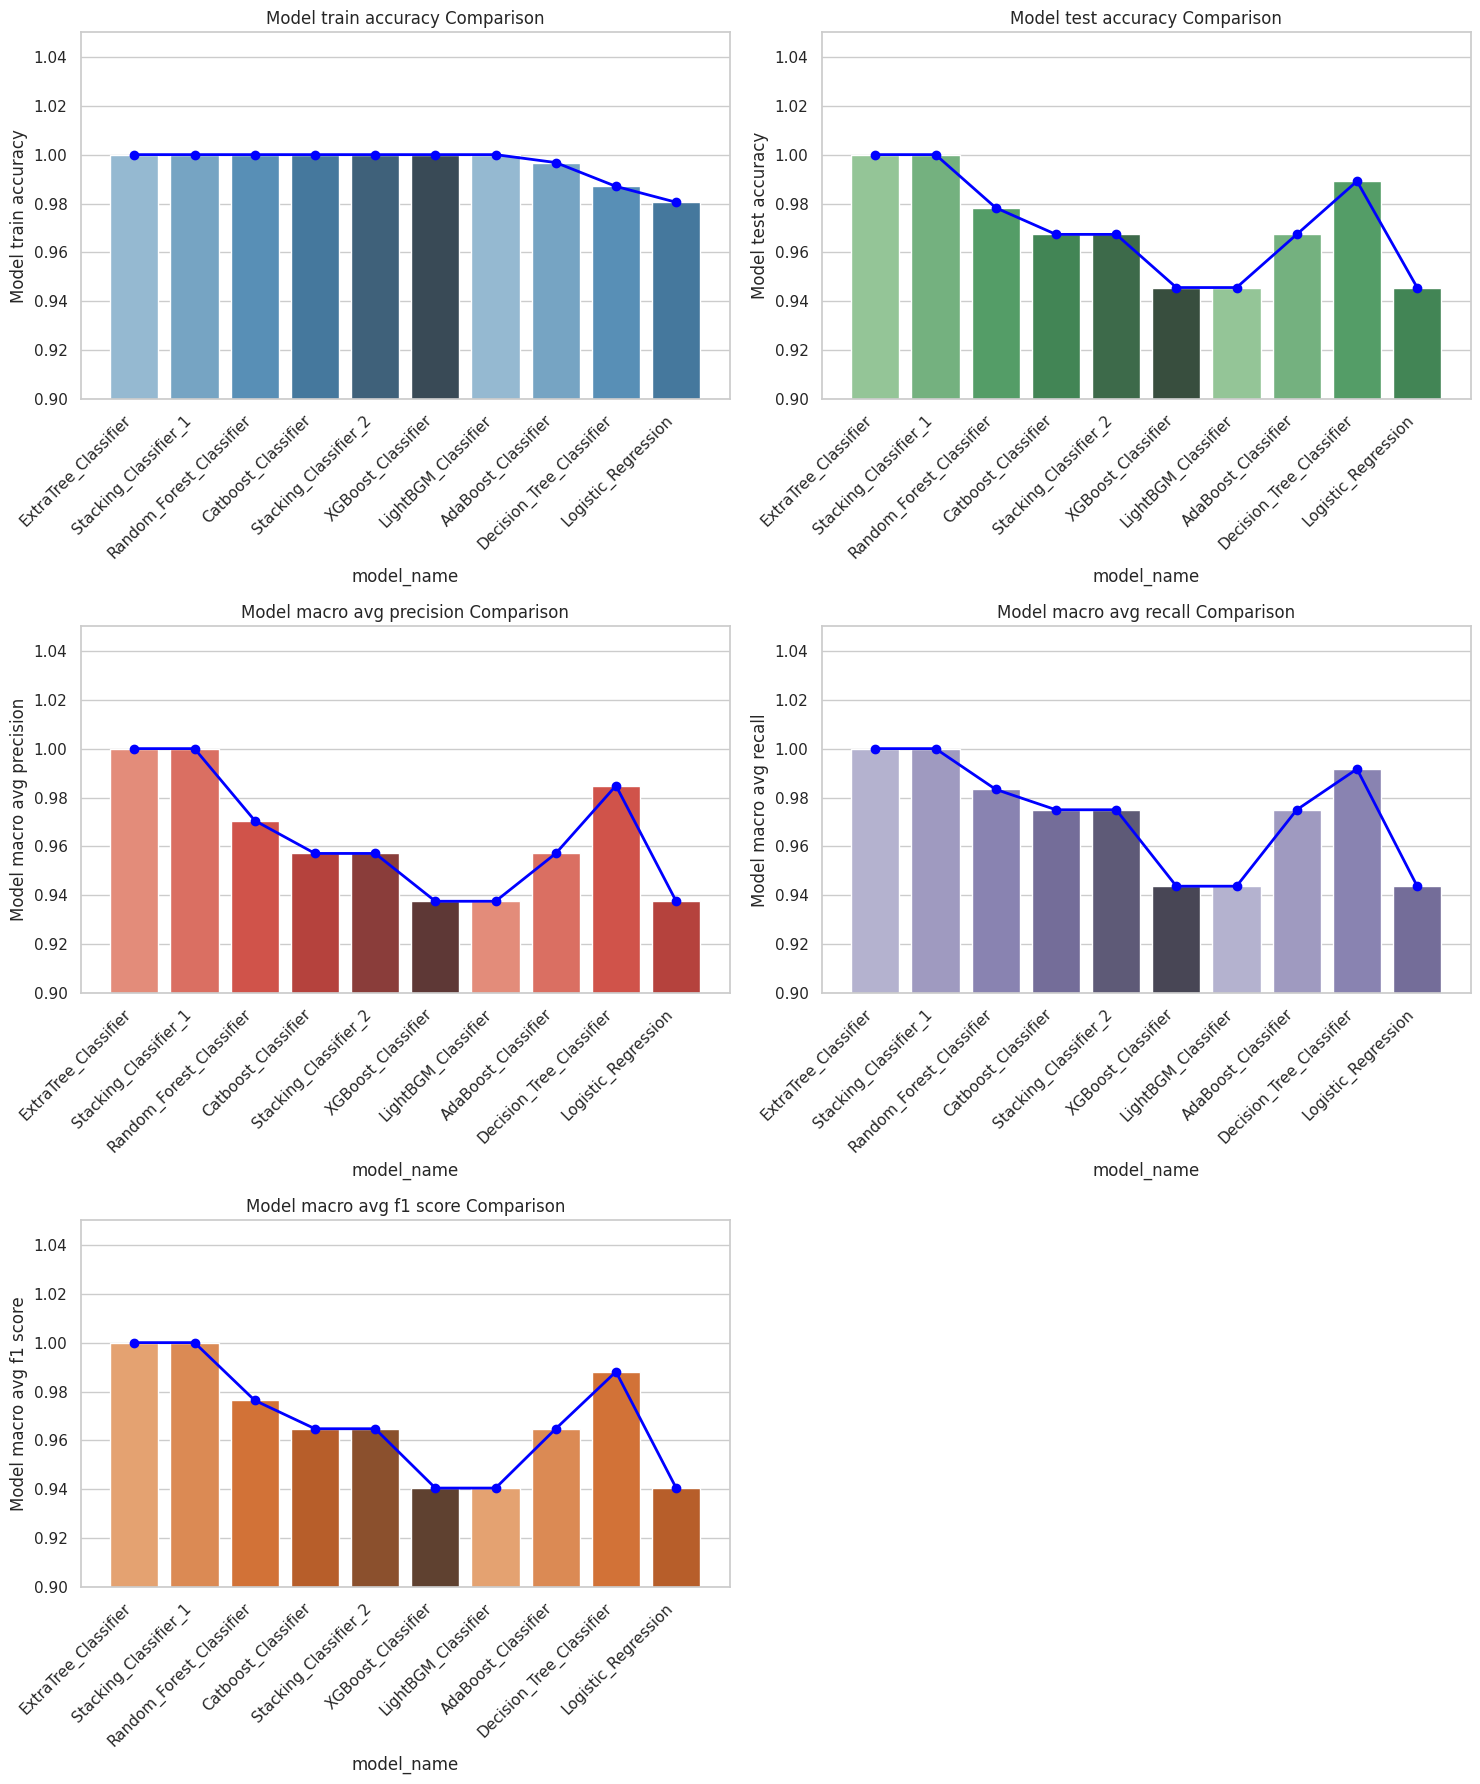

In [64]:
plot_metric_curves(model_res_df_sorted)

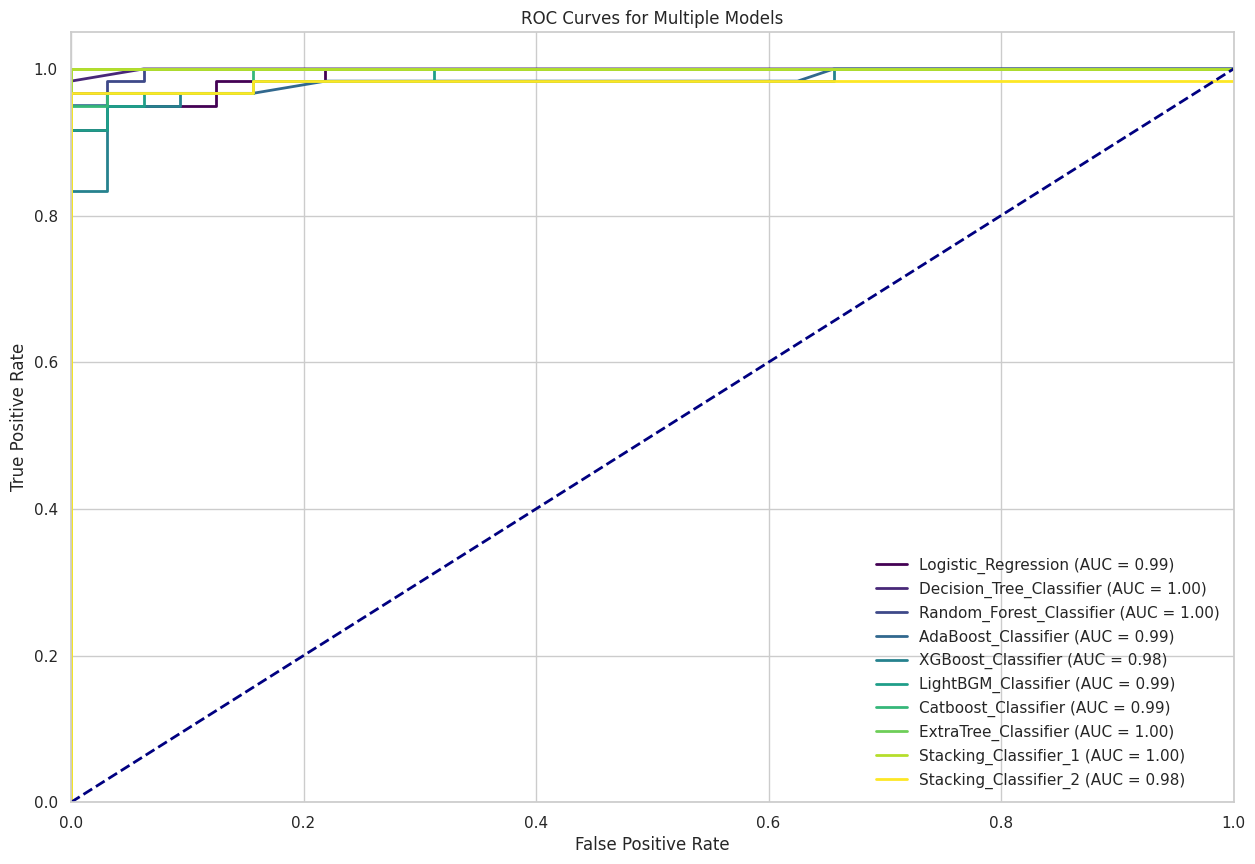

In [65]:
plot_roc_curves(model_res, y_test)

#### Normalized data results

In [66]:
model_res_norm

{'Logistic_Regression_norm': {'model': LogisticRegression(C=100),
  'pred_probs': array([[5.71148894e-01, 4.28851106e-01],
         [9.23017258e-01, 7.69827420e-02],
         [3.43015172e-10, 1.00000000e+00],
         [5.81756865e-14, 1.00000000e+00],
         [2.22044605e-15, 1.00000000e+00],
         [2.81996648e-14, 1.00000000e+00],
         [9.86330197e-01, 1.36698028e-02],
         [3.14332232e-02, 9.68566777e-01],
         [8.34292461e-01, 1.65707539e-01],
         [1.71598291e-10, 1.00000000e+00],
         [1.64313008e-14, 1.00000000e+00],
         [9.68717345e-01, 3.12826547e-02],
         [0.00000000e+00, 1.00000000e+00],
         [7.54951657e-14, 1.00000000e+00],
         [5.52083690e-09, 9.99999994e-01],
         [1.20322616e-04, 9.99879677e-01],
         [9.41360589e-01, 5.86394105e-02],
         [9.66143821e-01, 3.38561794e-02],
         [3.28458549e-09, 9.99999997e-01],
         [9.63102199e-01, 3.68978008e-02],
         [1.39300825e-07, 9.99999861e-01],
         [9.63520

In [67]:
model_res_norm_df = get_result_dataframe(model_res_norm)
model_res_norm_df

model_name  model_train_accuracy  model_test_accuracy  \
0       Logistic_Regression_norm              0.977273             0.978261   
1  Decision_Tree_Classifier_norm              1.000000             0.989130   
2  Random_Forest_Classifier_norm              1.000000             0.967391   
3       AdaBoost_Classifier_norm              0.996753             0.967391   
4        XGBoost_Classifier_norm              1.000000             0.945652   
5       LightBGM_Classifier_norm              1.000000             0.956522   
6       Catboost_Classifier_norm              1.000000             0.967391   
7      ExtraTree_Classifier_norm              1.000000             1.000000   
8     Stacking_Classifier_1_norm              1.000000             1.000000   
9     Stacking_Classifier_2_norm              1.000000             0.978261   

   model_macro_avg_precision  model_macro_avg_recall  model_macro_avg_f1_score  
0                   0.976042                0.976042                  0.976042  
1                   0.984848                0.991667                  0.988106  
2                   0.961222                0.967708                  0.964318  
3                   0.957143                0.975000                  0.964791  
4                   0.937596                0.943750                  0.940530  
5                   0.947262                0.959375                  0.952748  
6                   0.957143                0.975000                  0.964791  
7                   1.000000                1.000000                  1.000000  
8                   1.000000                1.000000                  1.000000  
9                   0.970588                0.983333                  0.976374

In [68]:
# Sort the DataFrame by all parameters except 'model_name' with appropriate ascending/descending
model_res_norm_df_sorted = model_res_norm_df.copy()
model_res_norm_df_sorted = model_res_norm_df_sorted.sort_values(by=['model_train_accuracy',
                               'model_test_accuracy',
                               'model_macro_avg_precision',
                               'model_macro_avg_recall',
                               'model_macro_avg_f1_score'],
                           ascending=[False, False, False, False, False])

# Display the sorted DataFrame
model_res_norm_df_sorted

model_name  model_train_accuracy  model_test_accuracy  \
7      ExtraTree_Classifier_norm              1.000000             1.000000   
8     Stacking_Classifier_1_norm              1.000000             1.000000   
1  Decision_Tree_Classifier_norm              1.000000             0.989130   
9     Stacking_Classifier_2_norm              1.000000             0.978261   
2  Random_Forest_Classifier_norm              1.000000             0.967391   
6       Catboost_Classifier_norm              1.000000             0.967391   
5       LightBGM_Classifier_norm              1.000000             0.956522   
4        XGBoost_Classifier_norm              1.000000             0.945652   
3       AdaBoost_Classifier_norm              0.996753             0.967391   
0       Logistic_Regression_norm              0.977273             0.978261   

   model_macro_avg_precision  model_macro_avg_recall  model_macro_avg_f1_score  
7                   1.000000                1.000000                  1.000000  
8                   1.000000                1.000000                  1.000000  
1                   0.984848                0.991667                  0.988106  
9                   0.970588                0.983333                  0.976374  
2                   0.961222                0.967708                  0.964318  
6                   0.957143                0.975000                  0.964791  
5                   0.947262                0.959375                  0.952748  
4                   0.937596                0.943750                  0.940530  
3                   0.957143                0.975000                  0.964791  
0                   0.976042                0.976042                  0.976042

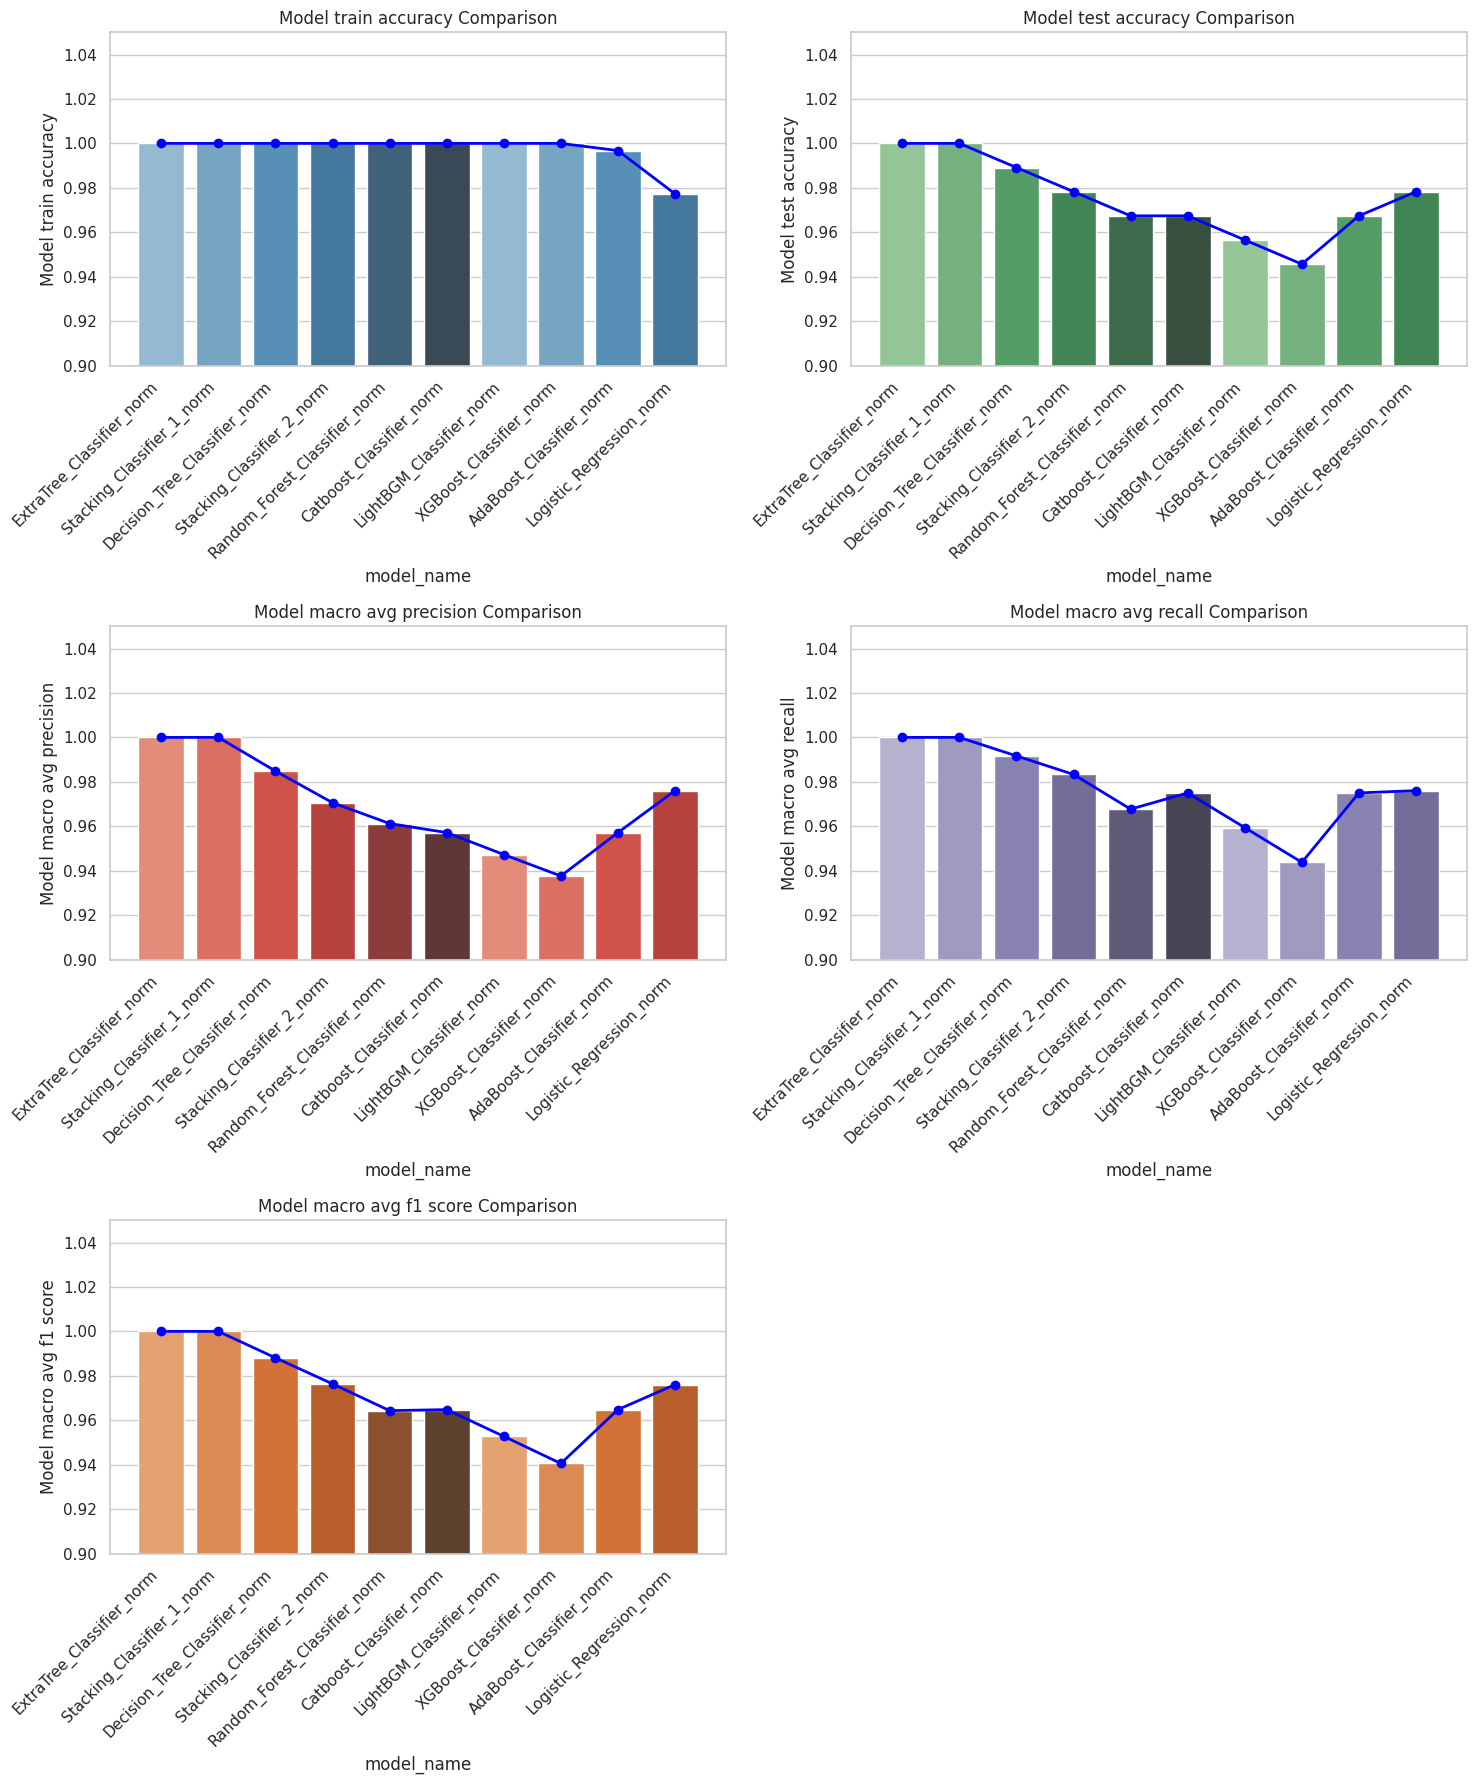

In [69]:
plot_metric_curves(model_res_norm_df_sorted)

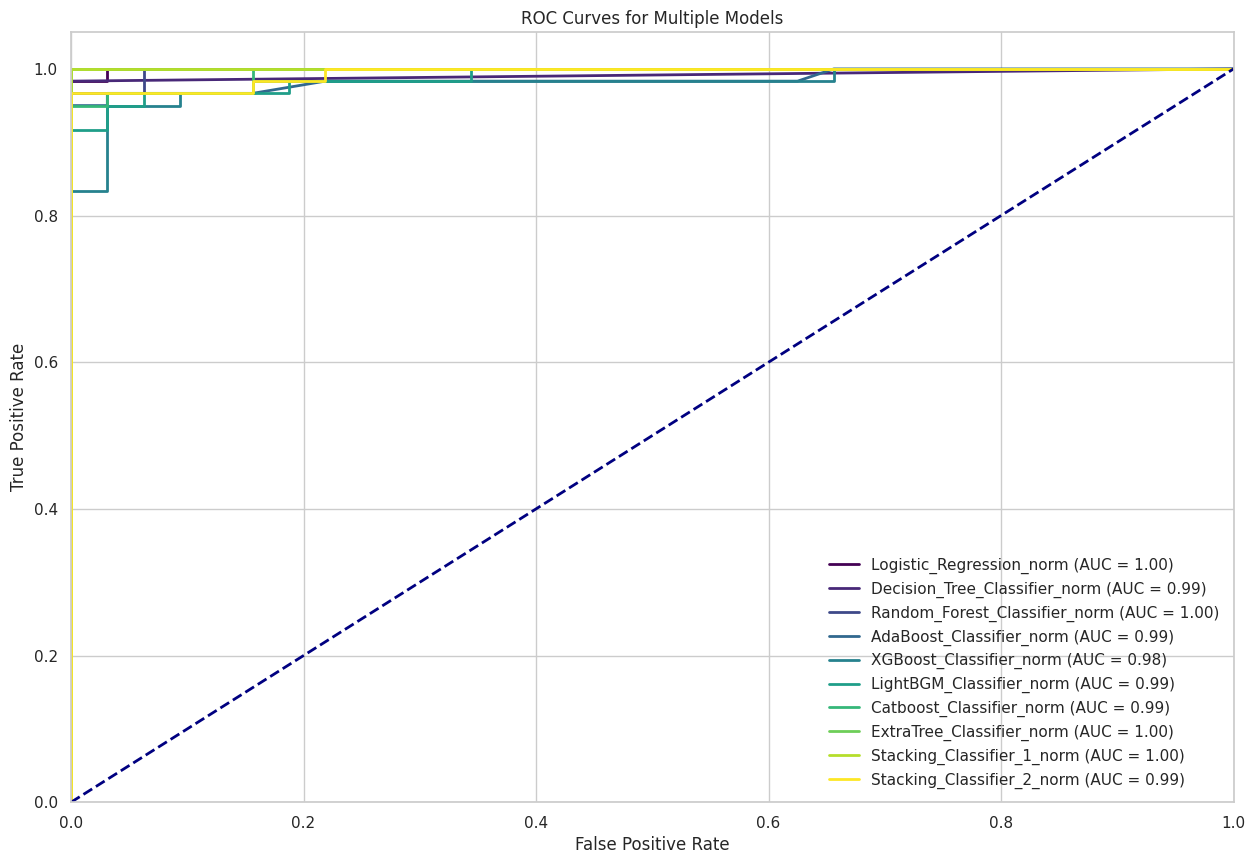

In [70]:
plot_roc_curves(model_res_norm, y_test)

#### Standardized data results

In [71]:
model_res_std

{'Logistic_Regression_std': {'model': LogisticRegression(C=100),
  'pred_probs': array([[4.78298914e-03, 9.95217011e-01],
         [9.86630523e-01, 1.33694773e-02],
         [3.77475828e-15, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [9.98944806e-01, 1.05519358e-03],
         [1.65429610e-02, 9.83457039e-01],
         [8.13015577e-01, 1.86984423e-01],
         [6.66133815e-16, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [9.97154300e-01, 2.84569954e-03],
         [0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 1.00000000e+00],
         [8.39524689e-05, 9.99916048e-01],
         [9.68546369e-01, 3.14536309e-02],
         [9.95274241e-01, 4.72575937e-03],
         [9.14601728e-13, 1.00000000e+00],
         [9.98699072e-01, 1.30092778e-03],
         [8.23439095e-11, 1.00000000e+00],
         [0.000000

In [72]:
model_res_std_df = get_result_dataframe(model_res_std)
model_res_std_df

model_name  model_train_accuracy  model_test_accuracy  \
0       Logistic_Regression_std              0.990260             0.989130   
1  Decision_Tree_Classifier_std              1.000000             0.956522   
2  Random_Forest_Classifier_std              1.000000             0.978261   
3       AdaBoost_Classifier_std              0.996753             0.967391   
4        XGBoost_Classifier_std              1.000000             0.945652   
5       LightBGM_Classifier_std              1.000000             0.956522   
6       Catboost_Classifier_std              1.000000             0.967391   
7      ExtraTree_Classifier_std              1.000000             1.000000   
8     Stacking_Classifier_1_std              1.000000             1.000000   
9     Stacking_Classifier_2_std              1.000000             0.978261   

   model_macro_avg_precision  model_macro_avg_recall  model_macro_avg_f1_score  
0                   0.991803                0.984375                  0.987931  
1                   0.952083                0.952083                  0.952083  
2                   0.970588                0.983333                  0.976374  
3                   0.957143                0.975000                  0.964791  
4                   0.937596                0.943750                  0.940530  
5                   0.947262                0.959375                  0.952748  
6                   0.957143                0.975000                  0.964791  
7                   1.000000                1.000000                  1.000000  
8                   1.000000                1.000000                  1.000000  
9                   0.970588                0.983333                  0.976374

In [73]:
# Sort the DataFrame by all parameters except 'model_name' with appropriate ascending/descending
model_res_std_df_sorted = model_res_std_df.copy()
model_res_std_df_sorted = model_res_std_df_sorted.sort_values(by=['model_train_accuracy',
                               'model_test_accuracy',
                               'model_macro_avg_precision',
                               'model_macro_avg_recall',
                               'model_macro_avg_f1_score'],
                           ascending=[False, False, False, False, False])

# Display the sorted DataFrame
model_res_std_df_sorted

model_name  model_train_accuracy  model_test_accuracy  \
7      ExtraTree_Classifier_std              1.000000             1.000000   
8     Stacking_Classifier_1_std              1.000000             1.000000   
2  Random_Forest_Classifier_std              1.000000             0.978261   
9     Stacking_Classifier_2_std              1.000000             0.978261   
6       Catboost_Classifier_std              1.000000             0.967391   
1  Decision_Tree_Classifier_std              1.000000             0.956522   
5       LightBGM_Classifier_std              1.000000             0.956522   
4        XGBoost_Classifier_std              1.000000             0.945652   
3       AdaBoost_Classifier_std              0.996753             0.967391   
0       Logistic_Regression_std              0.990260             0.989130   

   model_macro_avg_precision  model_macro_avg_recall  model_macro_avg_f1_score  
7                   1.000000                1.000000                  1.000000  
8                   1.000000                1.000000                  1.000000  
2                   0.970588                0.983333                  0.976374  
9                   0.970588                0.983333                  0.976374  
6                   0.957143                0.975000                  0.964791  
1                   0.952083                0.952083                  0.952083  
5                   0.947262                0.959375                  0.952748  
4                   0.937596                0.943750                  0.940530  
3                   0.957143                0.975000                  0.964791  
0                   0.991803                0.984375                  0.987931

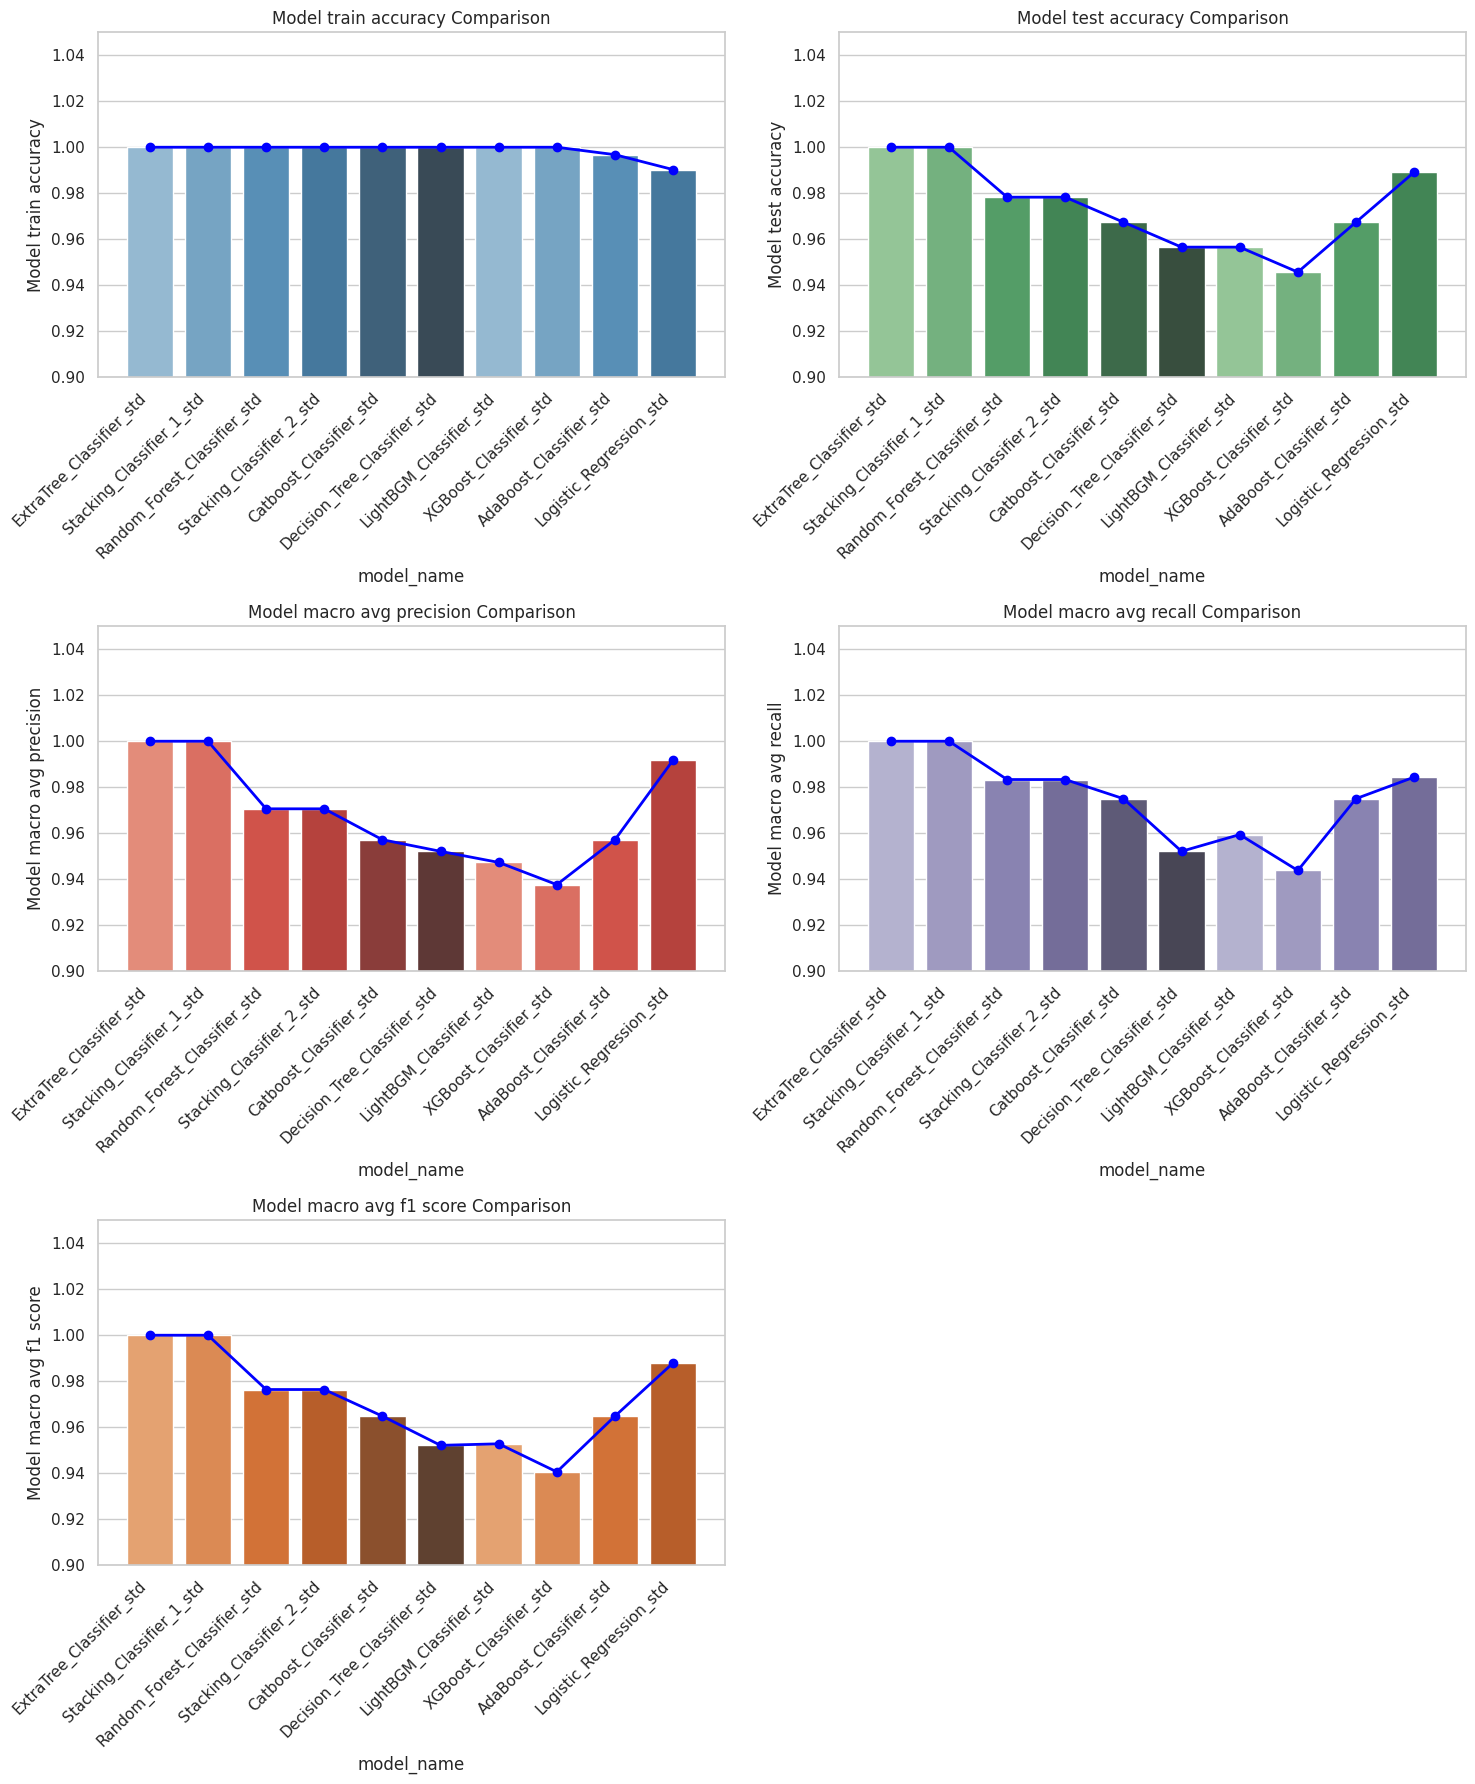

In [74]:
plot_metric_curves(model_res_std_df_sorted)

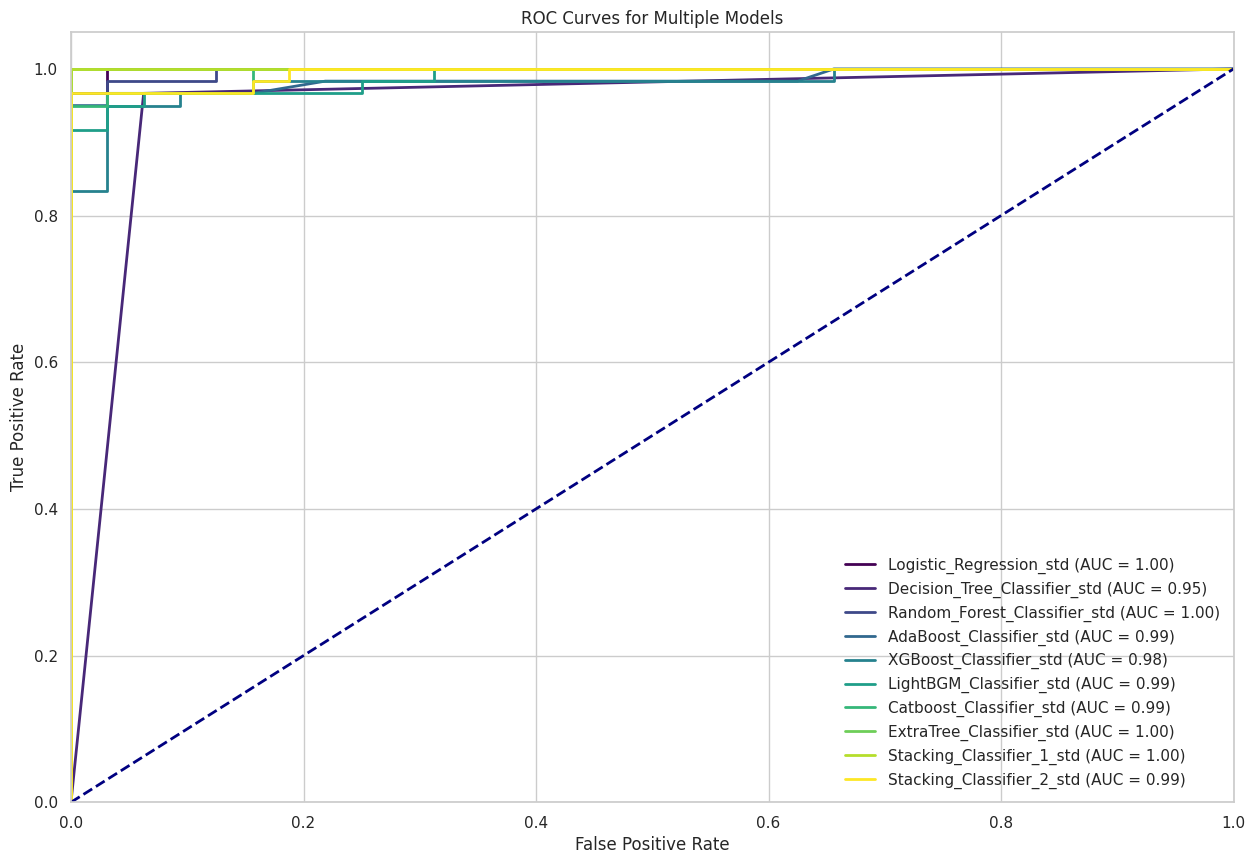

In [75]:
plot_roc_curves(model_res_std, y_test)

#### Combined data results

In [76]:
# Create DataFrames
df1 = model_res_df.copy()
df2 = model_res_norm_df.copy()
df3 = model_res_std_df.copy()

# Remove the suffixes ("_std" and "_norm") from data
df2['model_name'] = df2['model_name'].str.replace('_norm$', '', regex=True)
df3['model_name'] = df3['model_name'].str.replace('_std$', '', regex=True)

# Add a column to differentiate the datasets
df1['dataset'] = 'Original Data'
df2['dataset'] = 'Normalized Data'
df3['dataset'] = 'Standardized Data'

# Combine the datasets
df_combined = pd.concat([df1, df2, df3])

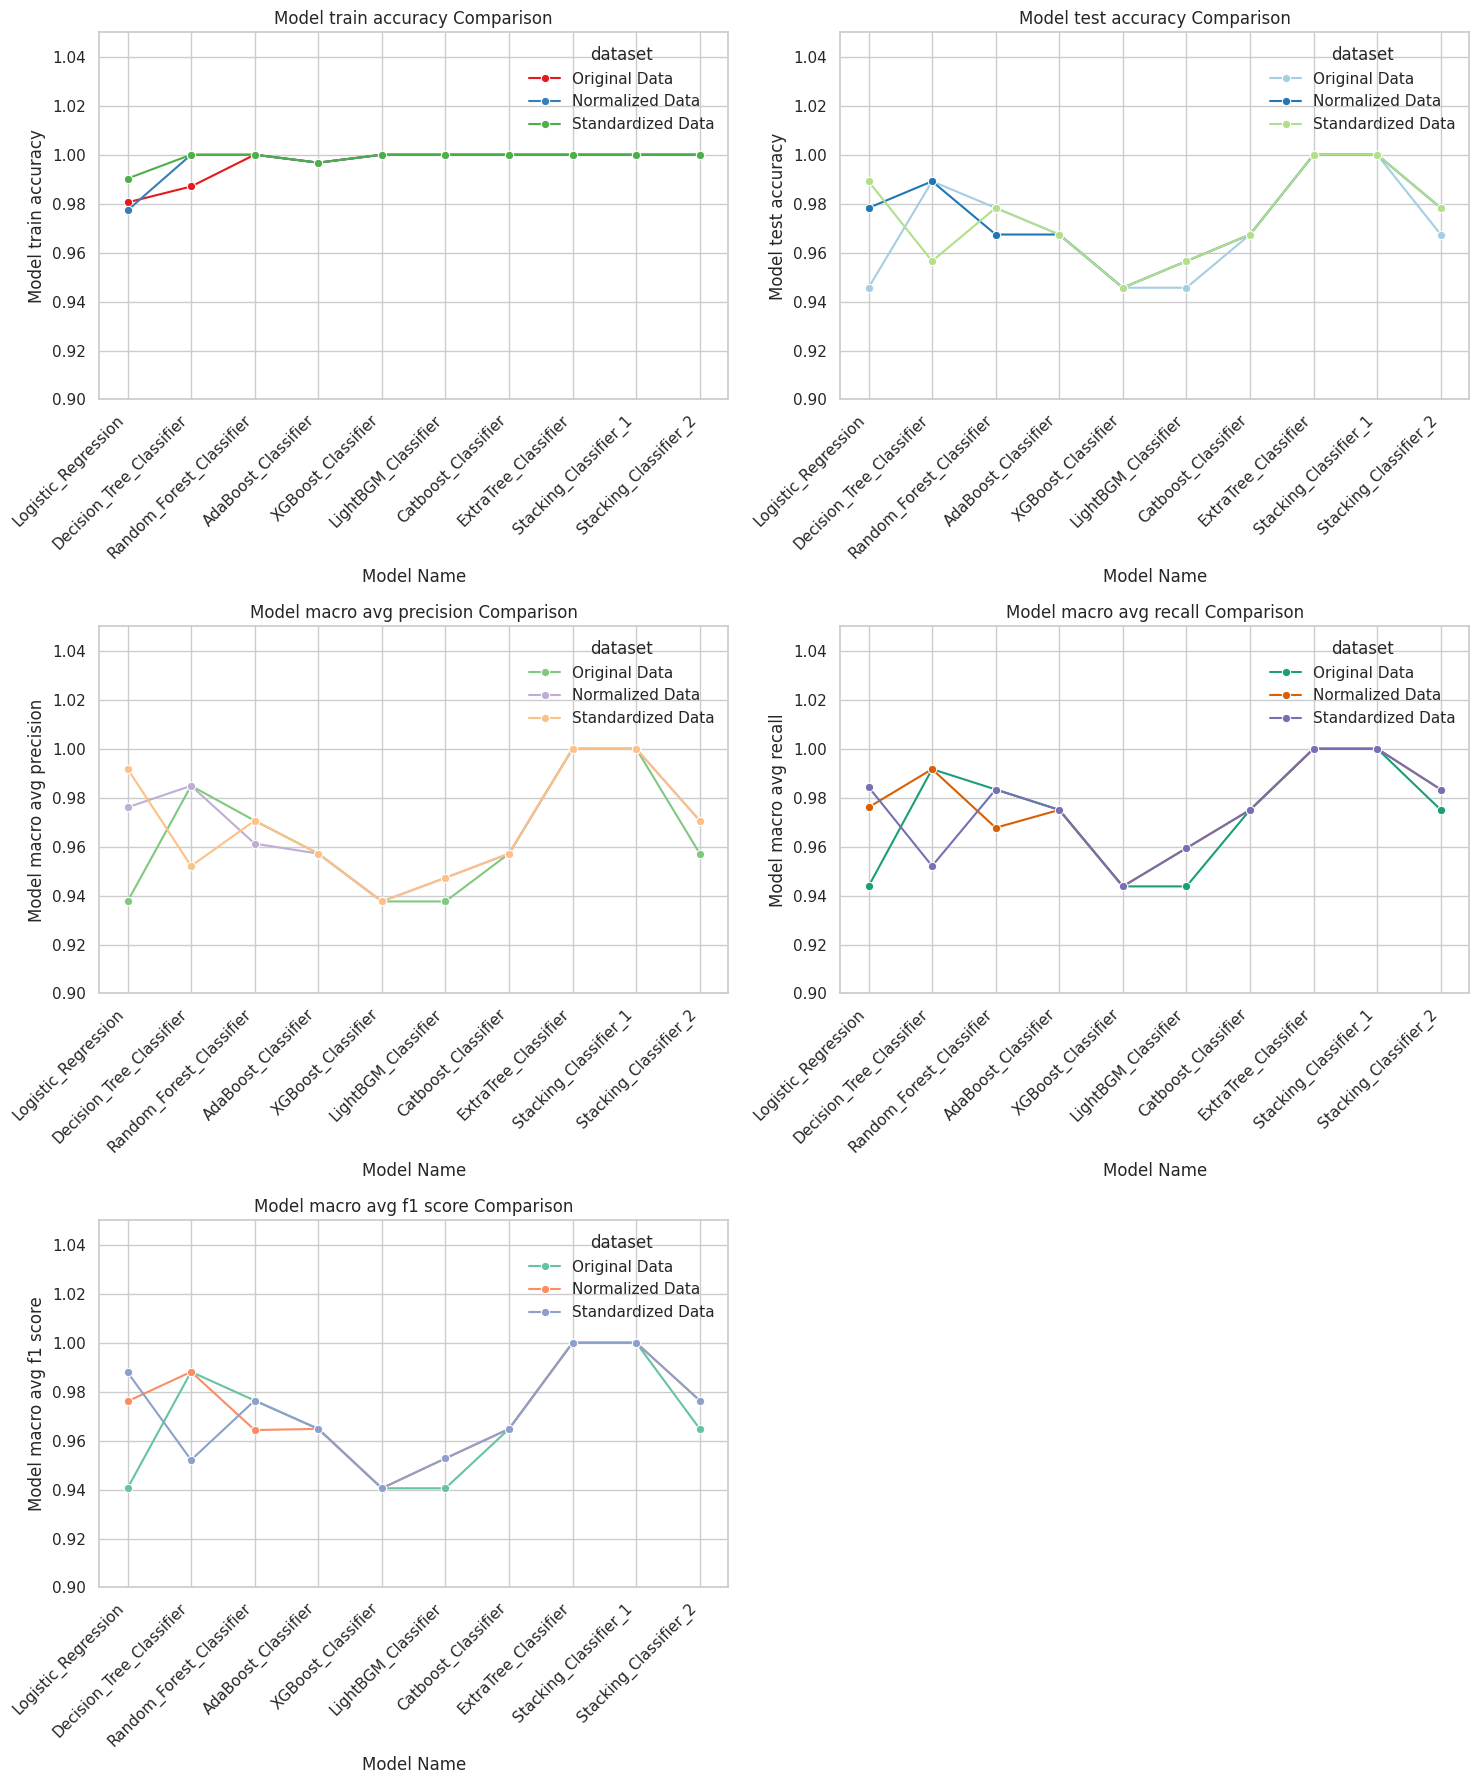

In [77]:
# Set the style
sns.set(style="whitegrid")

# Define a function to create line plots for each metric
def plot_comparison_metric(ax, metric, palette):
    sns.lineplot(x='model_name', y=metric, hue='dataset', data=df_combined, marker='o', ax=ax, palette=palette)
    ax.set_ylim(0.90, 1.05)
    ax.set_title(f'{metric.replace("_", " ").capitalize()} Comparison')
    ax.set_ylabel(metric.replace("_", " ").capitalize())
    ax.set_xlabel('Model Name')
    ax.set_xticklabels(df_combined['model_name'].unique(), rotation=45, ha='right')

# Create the subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Define different color palettes for each plot
palettes = [
    sns.color_palette("Set1", n_colors=3),
    sns.color_palette("Paired", n_colors=3),
    sns.color_palette("Accent", n_colors=3),
    sns.color_palette("Dark2", n_colors=3),
    sns.color_palette("Set2", n_colors=3)
]

metrics = [
    'model_train_accuracy', 'model_test_accuracy',
    'model_macro_avg_precision', 'model_macro_avg_recall',
    'model_macro_avg_f1_score'
]

# Plot each metric in a grid with different colors
for i, metric in enumerate(metrics):
    plot_comparison_metric(axes[i//2, i%2], metric, palettes[i])

# Hide the unused subplot (6th one)
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

### Best performance model selection

In [78]:
# Function to find the Matthews correlation coefficient (MCC), f1_score, cohens kappa and composite score for the models
def get_mcc_f1_kappa_cs(model_results, y_test):
  model_scores = {}
  model_name_lst = []
  mcc_lst = []
  f1_score_lst = []
  kappa_lst = []
  comp_score_lst = []
  for model_name, model_result in model_results.items():
      y_true = y_test
      y_pred = model_result['predictions']

      # Get all the three metrics
      mcc = matthews_corrcoef(y_true, y_pred)
      f1_score = model_result['class_report']['macro avg']['f1-score']
      kappa = cohen_kappa_score(y_true, y_pred)

      comp_score = (0.4 * f1_score) + (0.3 * mcc) + (0.3 * kappa)

      model_name_lst.append(model_name)
      mcc_lst.append(mcc)
      f1_score_lst.append(f1_score)
      kappa_lst.append(kappa)
      comp_score_lst.append(comp_score)

    # Store the metrics in a dictionary
  model_scores = {
      'model_name': model_name_lst, 'mcc': mcc_lst,
      'f1_score': f1_score_lst, 'kappa': kappa_lst,
      'composite_score': comp_score_lst
  }
  return model_scores

In [79]:
# Get the metric results for the three datasets
combined_metric_res = get_mcc_f1_kappa_cs(model_res | model_res_norm | model_res_std, y_test)
combined_metric_res

{'model_name': ['Logistic_Regression',
  'Decision_Tree_Classifier',
  'Random_Forest_Classifier',
  'AdaBoost_Classifier',
  'XGBoost_Classifier',
  'LightBGM_Classifier',
  'Catboost_Classifier',
  'ExtraTree_Classifier',
  'Stacking_Classifier_1',
  'Stacking_Classifier_2',
  'Logistic_Regression_norm',
  'Decision_Tree_Classifier_norm',
  'Random_Forest_Classifier_norm',
  'AdaBoost_Classifier_norm',
  'XGBoost_Classifier_norm',
  'LightBGM_Classifier_norm',
  'Catboost_Classifier_norm',
  'ExtraTree_Classifier_norm',
  'Stacking_Classifier_1_norm',
  'Stacking_Classifier_2_norm',
  'Logistic_Regression_std',
  'Decision_Tree_Classifier_std',
  'Random_Forest_Classifier_std',
  'AdaBoost_Classifier_std',
  'XGBoost_Classifier_std',
  'LightBGM_Classifier_std',
  'Catboost_Classifier_std',
  'ExtraTree_Classifier_std',
  'Stacking_Classifier_1_std',
  'Stacking_Classifier_2_std'],
 'mcc': [0.8813248186993657,
  0.9764913484180766,
  0.9538364228569945,
  0.931971796017148,
  0.88132

In [80]:
model_perf_df = pd.DataFrame(combined_metric_res)
model_perf_df

model_name       mcc  f1_score     kappa  \
0             Logistic_Regression  0.881325  0.940530  0.881075   
1        Decision_Tree_Classifier  0.976491  0.988106  0.976215   
2        Random_Forest_Classifier  0.953836  0.976374  0.952772   
3             AdaBoost_Classifier  0.931972  0.964791  0.929664   
4              XGBoost_Classifier  0.881325  0.940530  0.881075   
5             LightBGM_Classifier  0.881325  0.940530  0.881075   
6             Catboost_Classifier  0.931972  0.964791  0.929664   
7            ExtraTree_Classifier  1.000000  1.000000  1.000000   
8           Stacking_Classifier_1  1.000000  1.000000  1.000000   
9           Stacking_Classifier_2  0.931972  0.964791  0.929664   
10       Logistic_Regression_norm  0.952083  0.976042  0.952083   
11  Decision_Tree_Classifier_norm  0.976491  0.988106  0.976215   
12  Random_Forest_Classifier_norm  0.928908  0.964318  0.928645   
13       AdaBoost_Classifier_norm  0.931972  0.964791  0.929664   
14        XGBoost_Classifier_norm  0.881325  0.940530  0.881075   
15       LightBGM_Classifier_norm  0.906556  0.952748  0.905544   
16       Catboost_Classifier_norm  0.931972  0.964791  0.929664   
17      ExtraTree_Classifier_norm  1.000000  1.000000  1.000000   
18     Stacking_Classifier_1_norm  1.000000  1.000000  1.000000   
19     Stacking_Classifier_2_norm  0.953836  0.976374  0.952772   
20        Logistic_Regression_std  0.976150  0.987931  0.975866   
21   Decision_Tree_Classifier_std  0.904167  0.952083  0.904167   
22   Random_Forest_Classifier_std  0.953836  0.976374  0.952772   
23        AdaBoost_Classifier_std  0.931972  0.964791  0.929664   
24         XGBoost_Classifier_std  0.881325  0.940530  0.881075   
25        LightBGM_Classifier_std  0.906556  0.952748  0.905544   
26        Catboost_Classifier_std  0.931972  0.964791  0.929664   
27       ExtraTree_Classifier_std  1.000000  1.000000  1.000000   
28      Stacking_Classifier_1_std  1.000000  1.000000  1.000000   
29      Stacking_Classifier_2_std  0.953836  0.976374  0.952772   

    composite_score  
0          0.904932  
1          0.981054  
2          0.962532  
3          0.944407  
4          0.904932  
5          0.904932  
6          0.944407  
7          1.000000  
8          1.000000  
9          0.944407  
10         0.961667  
11         0.981054  
12         0.942993  
13         0.944407  
14         0.904932  
15         0.924729  
16         0.944407  
17         1.000000  
18         1.000000  
19         0.962532  
20         0.980777  
21         0.923333  
22         0.962532  
23         0.944407  
24         0.904932  
25         0.924729  
26         0.944407  
27         1.000000  
28         1.000000  
29         0.962532

In [81]:
model_perf_df_sorted = model_perf_df.sort_values(by=['mcc',
                               'f1_score',
                               'kappa',
                               'composite_score'],
                           ascending=[False, False, False, False])

# Display the sorted DataFrame
model_perf_df_sorted

model_name       mcc  f1_score     kappa  \
7            ExtraTree_Classifier  1.000000  1.000000  1.000000   
8           Stacking_Classifier_1  1.000000  1.000000  1.000000   
17      ExtraTree_Classifier_norm  1.000000  1.000000  1.000000   
18     Stacking_Classifier_1_norm  1.000000  1.000000  1.000000   
27       ExtraTree_Classifier_std  1.000000  1.000000  1.000000   
28      Stacking_Classifier_1_std  1.000000  1.000000  1.000000   
1        Decision_Tree_Classifier  0.976491  0.988106  0.976215   
11  Decision_Tree_Classifier_norm  0.976491  0.988106  0.976215   
20        Logistic_Regression_std  0.976150  0.987931  0.975866   
2        Random_Forest_Classifier  0.953836  0.976374  0.952772   
19     Stacking_Classifier_2_norm  0.953836  0.976374  0.952772   
22   Random_Forest_Classifier_std  0.953836  0.976374  0.952772   
29      Stacking_Classifier_2_std  0.953836  0.976374  0.952772   
10       Logistic_Regression_norm  0.952083  0.976042  0.952083   
3             AdaBoost_Classifier  0.931972  0.964791  0.929664   
6             Catboost_Classifier  0.931972  0.964791  0.929664   
9           Stacking_Classifier_2  0.931972  0.964791  0.929664   
13       AdaBoost_Classifier_norm  0.931972  0.964791  0.929664   
16       Catboost_Classifier_norm  0.931972  0.964791  0.929664   
23        AdaBoost_Classifier_std  0.931972  0.964791  0.929664   
26        Catboost_Classifier_std  0.931972  0.964791  0.929664   
12  Random_Forest_Classifier_norm  0.928908  0.964318  0.928645   
15       LightBGM_Classifier_norm  0.906556  0.952748  0.905544   
25        LightBGM_Classifier_std  0.906556  0.952748  0.905544   
21   Decision_Tree_Classifier_std  0.904167  0.952083  0.904167   
0             Logistic_Regression  0.881325  0.940530  0.881075   
4              XGBoost_Classifier  0.881325  0.940530  0.881075   
5             LightBGM_Classifier  0.881325  0.940530  0.881075   
14        XGBoost_Classifier_norm  0.881325  0.940530  0.881075   
24         XGBoost_Classifier_std  0.881325  0.940530  0.881075   

    composite_score  
7          1.000000  
8          1.000000  
17         1.000000  
18         1.000000  
27         1.000000  
28         1.000000  
1          0.981054  
11         0.981054  
20         0.980777  
2          0.962532  
19         0.962532  
22         0.962532  
29         0.962532  
10         0.961667  
3          0.944407  
6          0.944407  
9          0.944407  
13         0.944407  
16         0.944407  
23         0.944407  
26         0.944407  
12         0.942993  
15         0.924729  
25         0.924729  
21         0.923333  
0          0.904932  
4          0.904932  
5          0.904932  
14         0.904932  
24         0.904932

In [82]:
model_perf_df_sorted.columns

Index(['model_name', 'mcc', 'f1_score', 'kappa', 'composite_score'], dtype='object')

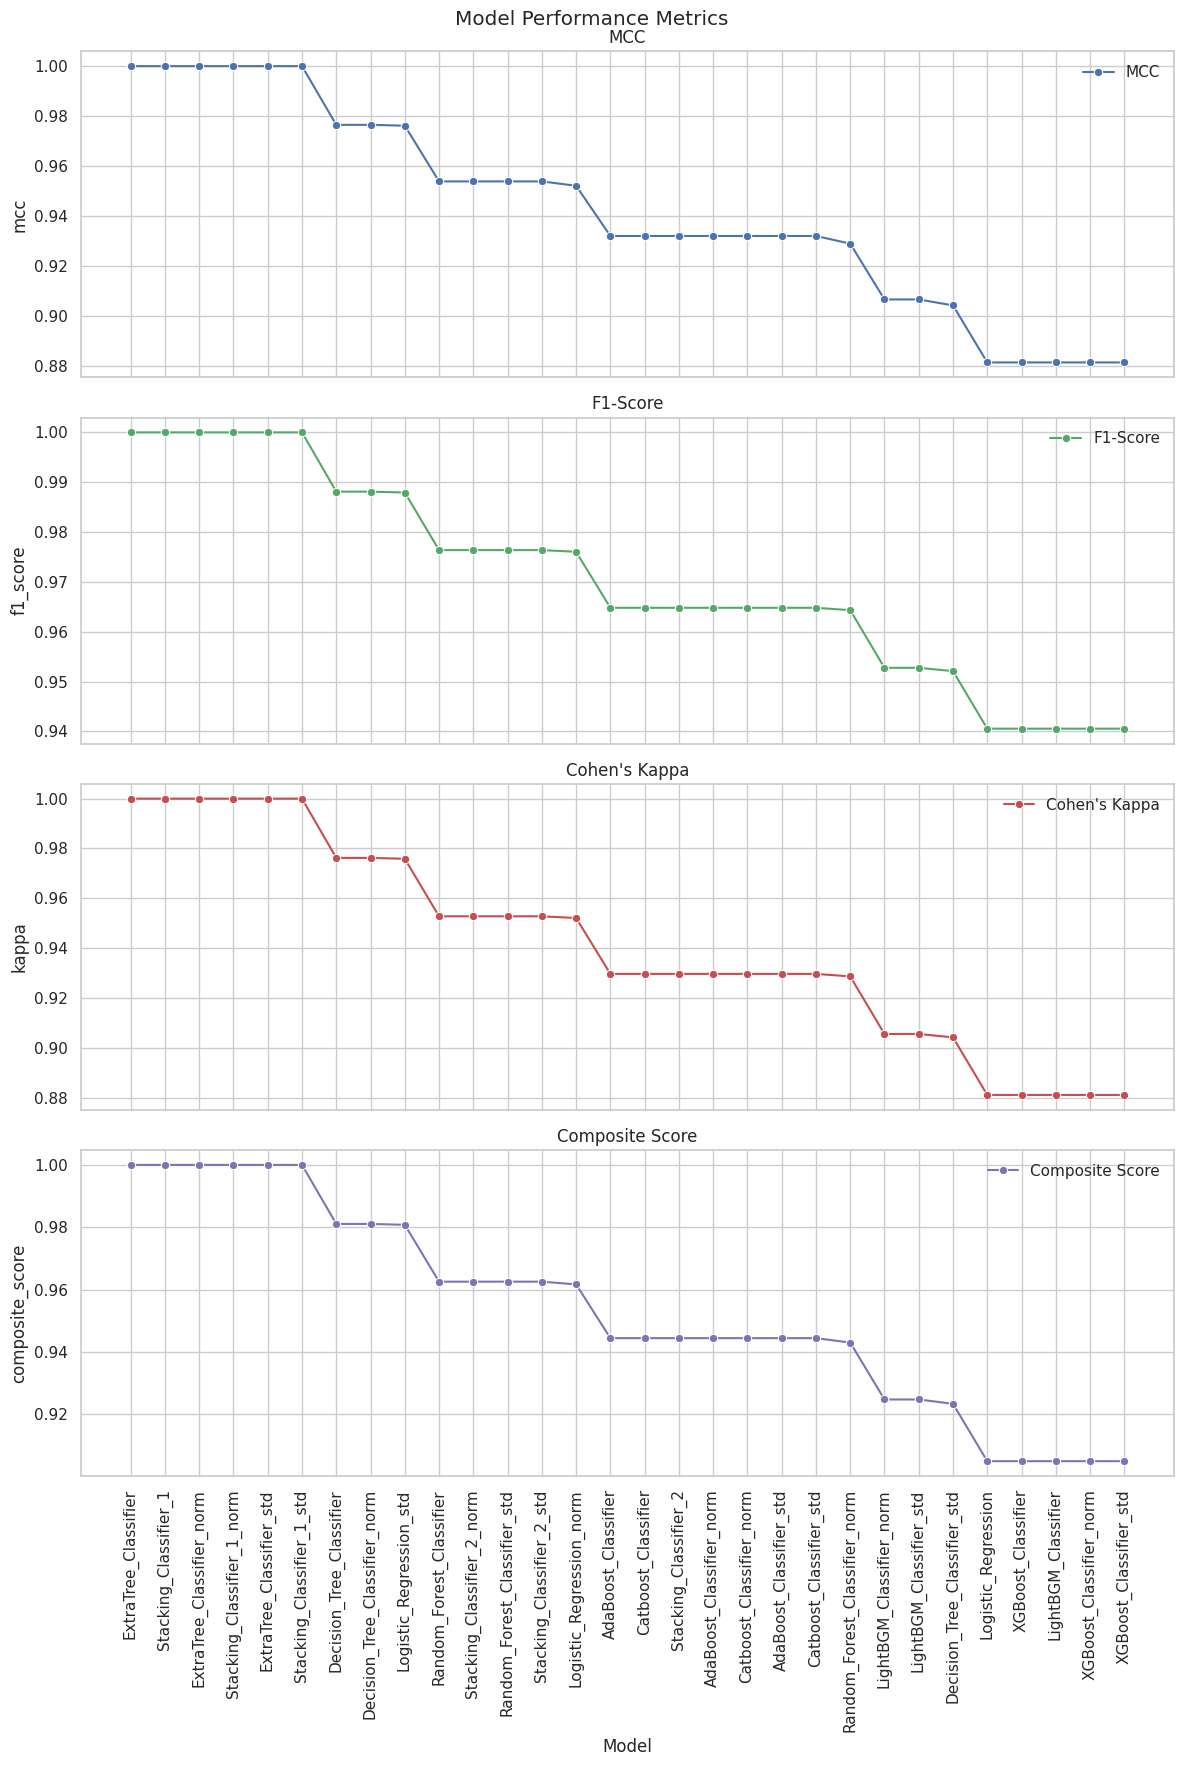

In [83]:
# Set the style
sns.set(style='whitegrid')

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 18), sharex=True)

# Plot MCC
sns.lineplot(ax=axes[0], x='model_name', y='mcc', data=model_perf_df_sorted, marker='o', color='b', label='MCC')
axes[0].set_title('MCC')
axes[0].legend()
axes[0].grid(True)

# Plot F1-Score
sns.lineplot(ax=axes[1], x='model_name', y='f1_score', data=model_perf_df_sorted, marker='o', color='g', label='F1-Score')
axes[1].set_title('F1-Score')
axes[1].legend()
axes[1].grid(True)

# Plot Cohen's Kappa
sns.lineplot(ax=axes[2], x='model_name', y='kappa', data=model_perf_df_sorted, marker='o', color='r', label="Cohen's Kappa")
axes[2].set_title("Cohen's Kappa")
axes[2].legend()
axes[2].grid(True)

# Plot Composite Score
sns.lineplot(ax=axes[3], x='model_name', y='composite_score', data=model_perf_df_sorted, marker='o', color='m', label='Composite Score')
axes[3].set_title('Composite Score')
axes[3].legend()
axes[3].grid(True)

# General settings
plt.xlabel('Model')
fig.suptitle('Model Performance Metrics')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

### Performing XAI algorithms

In [84]:
combined_res = (model_res | model_res_norm | model_res_std)

In [85]:
combined_res.keys()

dict_keys(['Logistic_Regression', 'Decision_Tree_Classifier', 'Random_Forest_Classifier', 'AdaBoost_Classifier', 'XGBoost_Classifier', 'LightBGM_Classifier', 'Catboost_Classifier', 'ExtraTree_Classifier', 'Stacking_Classifier_1', 'Stacking_Classifier_2', 'Logistic_Regression_norm', 'Decision_Tree_Classifier_norm', 'Random_Forest_Classifier_norm', 'AdaBoost_Classifier_norm', 'XGBoost_Classifier_norm', 'LightBGM_Classifier_norm', 'Catboost_Classifier_norm', 'ExtraTree_Classifier_norm', 'Stacking_Classifier_1_norm', 'Stacking_Classifier_2_norm', 'Logistic_Regression_std', 'Decision_Tree_Classifier_std', 'Random_Forest_Classifier_std', 'AdaBoost_Classifier_std', 'XGBoost_Classifier_std', 'LightBGM_Classifier_std', 'Catboost_Classifier_std', 'ExtraTree_Classifier_std', 'Stacking_Classifier_1_std', 'Stacking_Classifier_2_std'])

#### Implementing Lime algoithm

In [84]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=53fc1713b893b1a81df06ff0f96ec9d757db49cdaa55bc37920f272b330e845c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [107]:
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(training_data=X_train.values,
                                             feature_names=data_prp.columns.tolist()[:-1],
                                             class_names=['Not CKD', 'CKD'],
                                             mode='classification')

In [108]:
explainer

In [117]:
# Function to show the Lime plots
def show_lime_plots(model, test_data, num_instances):

  # Enhanced explanation visualization for multiple instances
  num_instances = num_instances

  # Use seaborn for better styling
  sns.set(style="whitegrid")

  for i in range(num_instances):
      instance = test_data.iloc[random.randint(1, test_data.shape[0]-1)]
      explanation = explainer.explain_instance(
          data_row=instance.values,
          predict_fn=model.predict_proba
      )

      # Get the explanation in a dataframe format
      exp_df = pd.DataFrame(explanation.as_list(), columns=['Feature', 'Importance'])

      # Plot using plotly for interactive visualization
      fig = px.bar(exp_df, x='Importance', y='Feature', orientation='h', title=f'LIME Explanation for Instance {i}')
      fig.update_layout(
          xaxis_title="Feature Importance",
          yaxis_title="Feature",
          yaxis={'categoryorder':'total ascending'},
          template='plotly_white'
      )
      fig.show()


##### Decision Tree Classifier

In [131]:
show_lime_plots(combined_res['Decision_Tree_Classifier']['model'], X_test, 5)

##### ExtraTree Classifier

In [133]:
show_lime_plots(combined_res['ExtraTree_Classifier']['model'], X_test, 5)

##### Stacking Classifier 1

In [121]:
show_lime_plots(combined_res['Stacking_Classifier_1']['model'], X_test, 5)

##### Random Forest Classifier

In [139]:
show_lime_plots(combined_res['Random_Forest_Classifier']['model'], X_test, 5)

#### Implementing Eli5 algorithm

In [145]:
!pip install eli5

In [146]:
import eli5
from eli5.sklearn import PermutationImportance

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py)

##### Decision Tree Classifier

In [136]:
model = combined_res['Decision_Tree_Classifier']['model']
model

DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=3)

In [137]:
# Global feature importance using the built-in method
global_explanation = eli5.show_weights(model, feature_names=X_train.columns.tolist())
display(global_explanation)

NameError: name 'eli5' is not defined

##### ExtraTree Classifier

##### Stacking Classifier 1

##### Random Forest Classifier

#### Implementing SHAP algorithm

In [86]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 27.5 MB/s eta 0:00:00


In [87]:
import shap

In [168]:
# Global explanations for the model
def getGlobalExplanation(explainer, X_test):

  # Calculate SHAP values for the test set
  shap_values = explainer(X_test, check_additivity=False)

  # Compute the mean absolute SHAP value for each feature (positive class, index 1)
  mean_abs_shap_values = np.abs(shap_values.values[:, :, 1]).mean(axis=0)

  # Convert SHAP values to a DataFrame for Plotly
  importance_df = pd.DataFrame({
      'Feature': X_test.columns,
      'SHAP Value': mean_abs_shap_values
  }).sort_values(by='SHAP Value', ascending=False)

  # Create an interactive bar plot
  fig = px.bar(importance_df, x='SHAP Value', y='Feature', orientation='h',
              title='Global Feature Importance',
              labels={'SHAP Value': 'Average Absolute SHAP Value', 'Feature': 'Feature'},
              color='SHAP Value',
              color_continuous_scale=px.colors.sequential.Viridis)

  fig.update_layout(
      xaxis_title='Average Absolute SHAP Value',
      yaxis_title='Feature',
      template='plotly_white'
  )

  fig.show()

In [166]:
# Local explanation for a single instance
def getLocalExplanation(explainer, X_test, num_instance):

  for i in range(num_instance):
    instance_index = random.randint(0, X_test.shape[0]-1)
    instance = X_test.iloc[instance_index: instance_index+1]
    shap_values_single = explainer.shap_values(instance, check_additivity=False)

    shap_values_df = pd.DataFrame({
        'Feature': X_test.columns,
        'SHAP Value': shap_values_single[0][:,1]  # Use the SHAP values for the positive class (index 1)
    }).sort_values(by='SHAP Value', ascending=False)

    fig = px.bar(shap_values_df, x='SHAP Value', y='Feature', orientation='h',
                title=f'Local Explanation for Instance {i+1}',
                labels={'SHAP Value': 'SHAP Value', 'Feature': 'Feature'},
                color='SHAP Value',
                color_continuous_scale=px.colors.sequential.Viridis)

    fig.update_layout(
        xaxis_title='SHAP Value',
        yaxis_title='Feature',
        template='plotly_white'
    )

    fig.show()

##### Decision Tree Classifier

In [107]:
model = combined_res['Decision_Tree_Classifier']['model']

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

In [108]:
getGlobalExplanation(explainer, X_test)

In [123]:
getLocalExplanation(explainer, X_test, 5)

##### ExtraTree Classifier

In [124]:
model = combined_res['ExtraTree_Classifier']['model']

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

In [125]:
getGlobalExplanation(explainer, X_test)

In [126]:
getLocalExplanation(explainer, X_test, 5)

##### Stacking Classifier 1

In [150]:
model = combined_res['Stacking_Classifier_1']['model']

def custom_predict(X):
    return model.predict_proba(X)

# Create a SHAP explainer
explainer = shap.Explainer(custom_predict, X_train)

In [129]:
getGlobalExplanation(explainer, X_test)

PermutationExplainer explainer: 93it [01:52,  1.27s/it]


In [153]:
getLocalExplanation(explainer, X_test, 5)

##### Random Forest Classifier

In [161]:
model = combined_res['Random_Forest_Classifier']['model']

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)
explainer.check_additivity = False

In [169]:
getGlobalExplanation(explainer, X_test)

In [167]:
getLocalExplanation(explainer, X_test, 5)

### XAI Explainer Evaluation using LEAF